# Setup

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from typing import Dict, List, Tuple, Callable

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.utils import resample

from pathlib import Path
import warnings, re
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=re.compile(r".*'force_all_finite'.*will be removed in 1\.8.*").pattern
)

plt.rcParams["figure.dpi"] = 160
sns.set_context("notebook")

In [2]:
# Load core view
p = Path("data/processed") / "hbn_core_view_v1.csv"
df = pd.read_csv(p)

In [3]:
import os

def find_project_root(start: Path | None = None) -> Path:
    """Return the repo root by searching upward for markers."""
    p = (start or Path.cwd()).resolve()
    markers = {".git", "environment.yml", "README.md"}
    while True:
        if any((p/m).exists() for m in markers):
            return p
        if p.parent == p:
            # fallback: use start if nothing found
            return (start or Path.cwd()).resolve()
        p = p.parent

# allow manual override via env var if needed (e.g., in CI/Colab)
ROOT = Path(os.environ.get("HBN_PROJ_ROOT", find_project_root()))
DATA_DIR     = ROOT / "data"
RESULTS_DIR  = ROOT / "results" / "clustering_method_selection"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", ROOT)
print("Results dir :", RESULTS_DIR)

Project root: /Users/yizj/Desktop/hbn_project
Results dir : /Users/yizj/Desktop/hbn_project/results/clustering_method_selection


# Preprocess

## Choose columns (Primary: age-corrected EF + TD) + profiling cols

In [4]:
def pick(df, prefer, fallback=None, must=True):
    prefer = prefer if isinstance(prefer, (list, tuple)) else [prefer]
    for c in prefer:
        if c in df.columns:
            return c
    if fallback:
        fallback = fallback if isinstance(fallback, (list, tuple)) else [fallback]
        for c in fallback:
            if c in df.columns:
                return c
    if must:
        raise KeyError(f"Missing any of: {prefer + (fallback or [])}")
    return None

# Age-corrected EF (preferred); graceful fallbacks if needed
COL_FLANK = pick(df,
    ["NIH_final,NIH_Flanker_Age_Corr_Stnd"],
    fallback=["NIH_final,NIH_Flanker_Computed_Score"]
)
COL_LIST  = pick(df,
    ["NIH_final,NIH_List_Sort_Age_Corr_Stnd"],
    fallback=["NIH_final,NIH_List_Sort_Uncorr_Stnd","NIH_final,NIH_List_Sort_Raw"]
)
COL_PROC  = pick(df,
    ["NIH_final,NIH_Processing_Age_Corr_Stnd"],
    fallback=["NIH_final,NIH_Processing_Computed_Score"]
)

# Temporal discounting summary features
TD_COLS = ["logk_mean","k_abs_diff_log"]
for c in TD_COLS:
    if c not in df.columns:
        raise KeyError(f"Missing TD feature: {c}")

FEATURES = [COL_FLANK, COL_LIST, COL_PROC] + TD_COLS
PROFILE_ONLY = ["Age","Sex"]  # profiled later (not used to cluster)

print("Clustering features:", FEATURES)
print("Profile-only cols :", PROFILE_ONLY)

Clustering features: ['NIH_final,NIH_Flanker_Age_Corr_Stnd', 'NIH_final,NIH_List_Sort_Age_Corr_Stnd', 'NIH_final,NIH_Processing_Age_Corr_Stnd', 'logk_mean', 'k_abs_diff_log']
Profile-only cols : ['Age', 'Sex']


## Build X, check missingness, impute + scale

In [5]:
# X (for clustering) and a profiling frame
X = df[FEATURES].copy()
prof = pd.concat([X, df[PROFILE_ONLY]], axis=1)

# Normalize Sex to 0/1 for profiling %
if "Sex" in prof.columns and prof["Sex"].dtype == "O":
    prof["Sex"] = (prof["Sex"].astype(str).str.strip().str.lower()
                   .map({"male":1,"m":1,"female":0,"f":0}))

# Column-wise missingness (%)
miss_col = X.isna().mean().sort_values(ascending=False)
display(miss_col.to_frame("missing_pct"))

# How many cells will be imputed per column?
cells_to_impute = X.isna().sum().rename("n_imputed_if_median")
display(cells_to_impute.to_frame())

# Impute (median) + scale (z) for clustering
pre = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])
Xp = pre.fit_transform(X)
Xp.shape

missing_pct
k_abs_diff_log                             0.033924
NIH_final,NIH_Flanker_Age_Corr_Stnd        0.000000
NIH_final,NIH_List_Sort_Age_Corr_Stnd      0.000000
NIH_final,NIH_Processing_Age_Corr_Stnd     0.000000
logk_mean                                  0.000000

n_imputed_if_median
NIH_final,NIH_Flanker_Age_Corr_Stnd                       0
NIH_final,NIH_List_Sort_Age_Corr_Stnd                     0
NIH_final,NIH_Processing_Age_Corr_Stnd                    0
logk_mean                                                 0
k_abs_diff_log                                           67

(1975, 5)

## Pre-clustering visuals

Understand EF–TD relations before clustering.

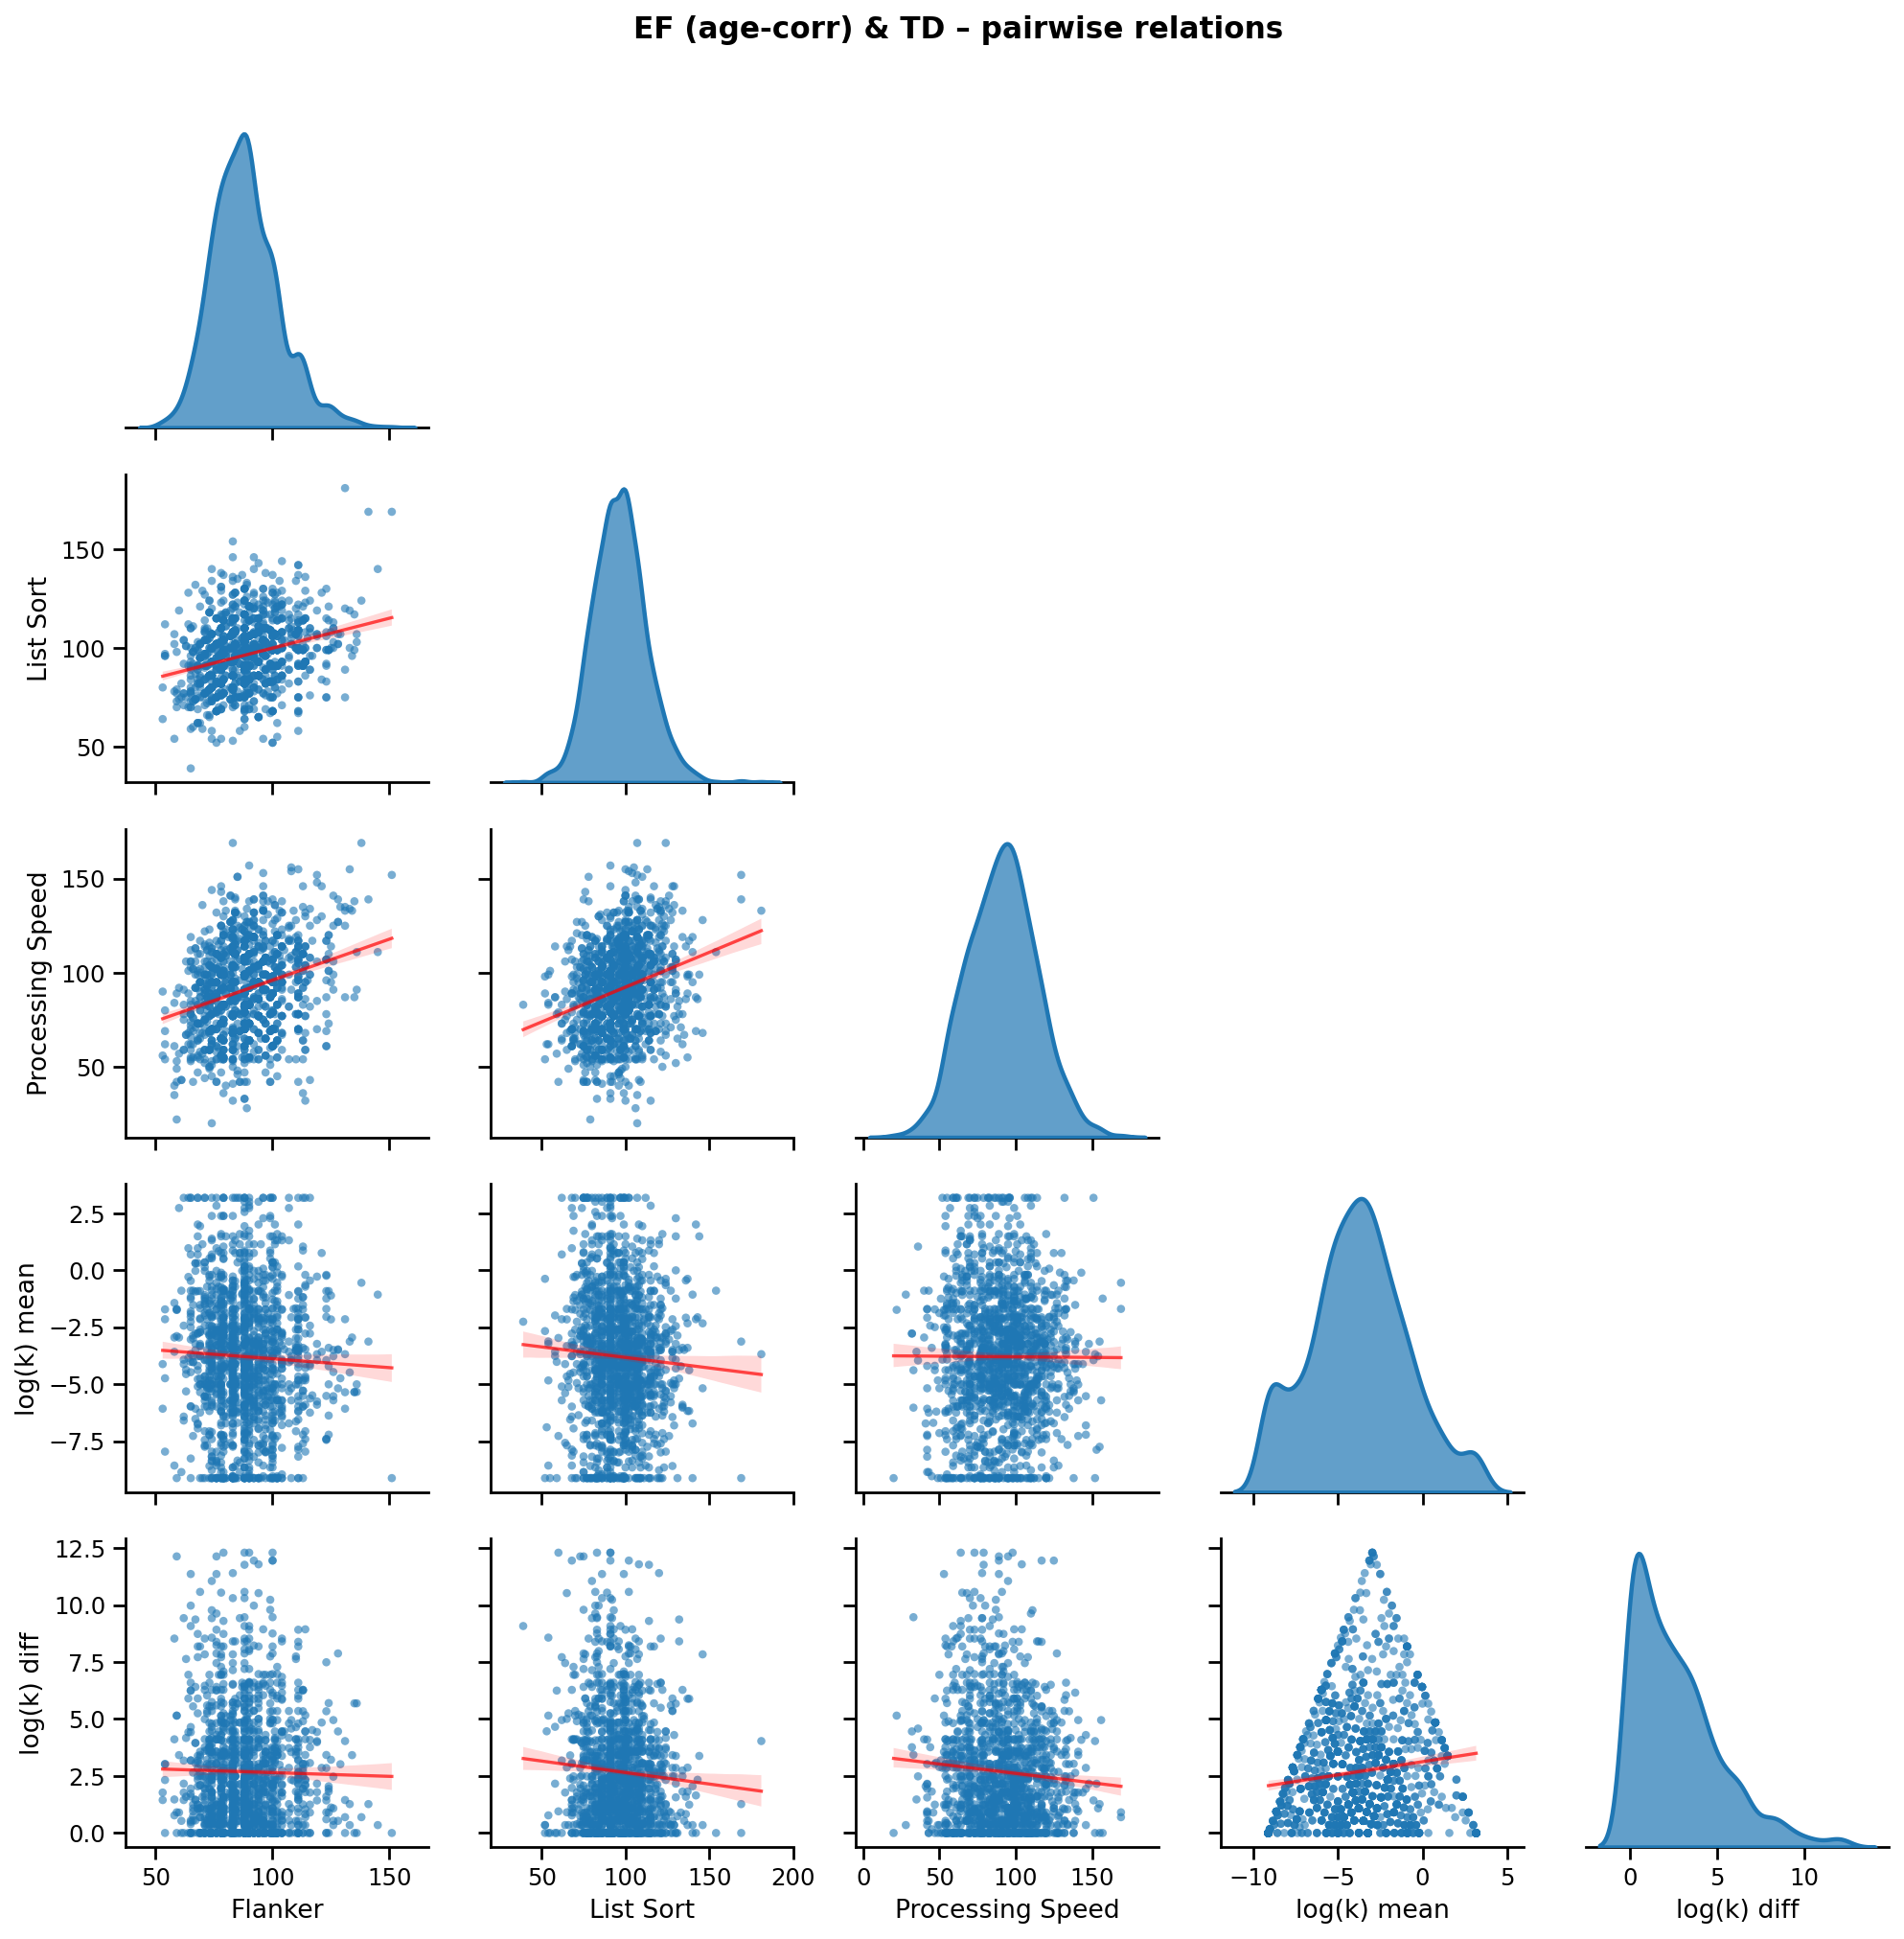

In [58]:
FEATURE_LABELS = {
    COL_FLANK: 'Flanker',
    COL_LIST: 'List Sort', 
    COL_PROC: 'Processing Speed',
    'logk_mean': 'log(k) mean',
    'k_abs_diff_log': 'log(k) diff'
}

# Pairwise relations with CLEAN LABELS
sub = prof[FEATURES].sample(n=min(1500, len(prof)), random_state=0)

# Rename columns for cleaner display
sub_clean = sub.rename(columns=FEATURE_LABELS)

# Create pairplot with improved styling
pairplot_fig = sns.pairplot(
    sub_clean, 
    diag_kind="kde",           # KDE instead of histogram
    corner=True,
    plot_kws={
        'alpha': 0.6,          # Semi-transparent points
        's': 15,               # Smaller point size
        'edgecolor': 'none'    # No edge around points
    },
    diag_kws={
        'linewidth': 2,        # Thicker KDE lines
        'alpha': 0.7
    }
)

# Add regression lines to scatter plots
clean_features = [FEATURE_LABELS[f] for f in FEATURES]
for i in range(len(clean_features)):
    for j in range(i):
        ax = pairplot_fig.axes[i, j]
        if ax is not None:
            # Get data from the current subplot
            x_data = sub_clean[clean_features[j]].dropna()
            y_data = sub_clean[clean_features[i]].dropna()
            # Align the data
            valid_idx = x_data.index.intersection(y_data.index)
            if len(valid_idx) > 2:
                x_clean = x_data.loc[valid_idx]
                y_clean = y_data.loc[valid_idx]
                # Add regression line
                sns.regplot(
                    x=x_clean, 
                    y=y_clean, 
                    scatter=False, 
                    ax=ax, 
                    color='red', 
                    line_kws={'linewidth': 1.5, 'alpha': 0.7}
                )

pairplot_fig.fig.suptitle("EF (age-corr) & TD – pairwise relations", 
                          y=1.01, fontsize=14, fontweight='bold')
pairplot_fig.fig.tight_layout()

# Save pairplot
pairplot_path = RESULTS_DIR / "pairplot_features.png"
pairplot_fig.savefig(pairplot_path, dpi=300, bbox_inches='tight')
plt.show()

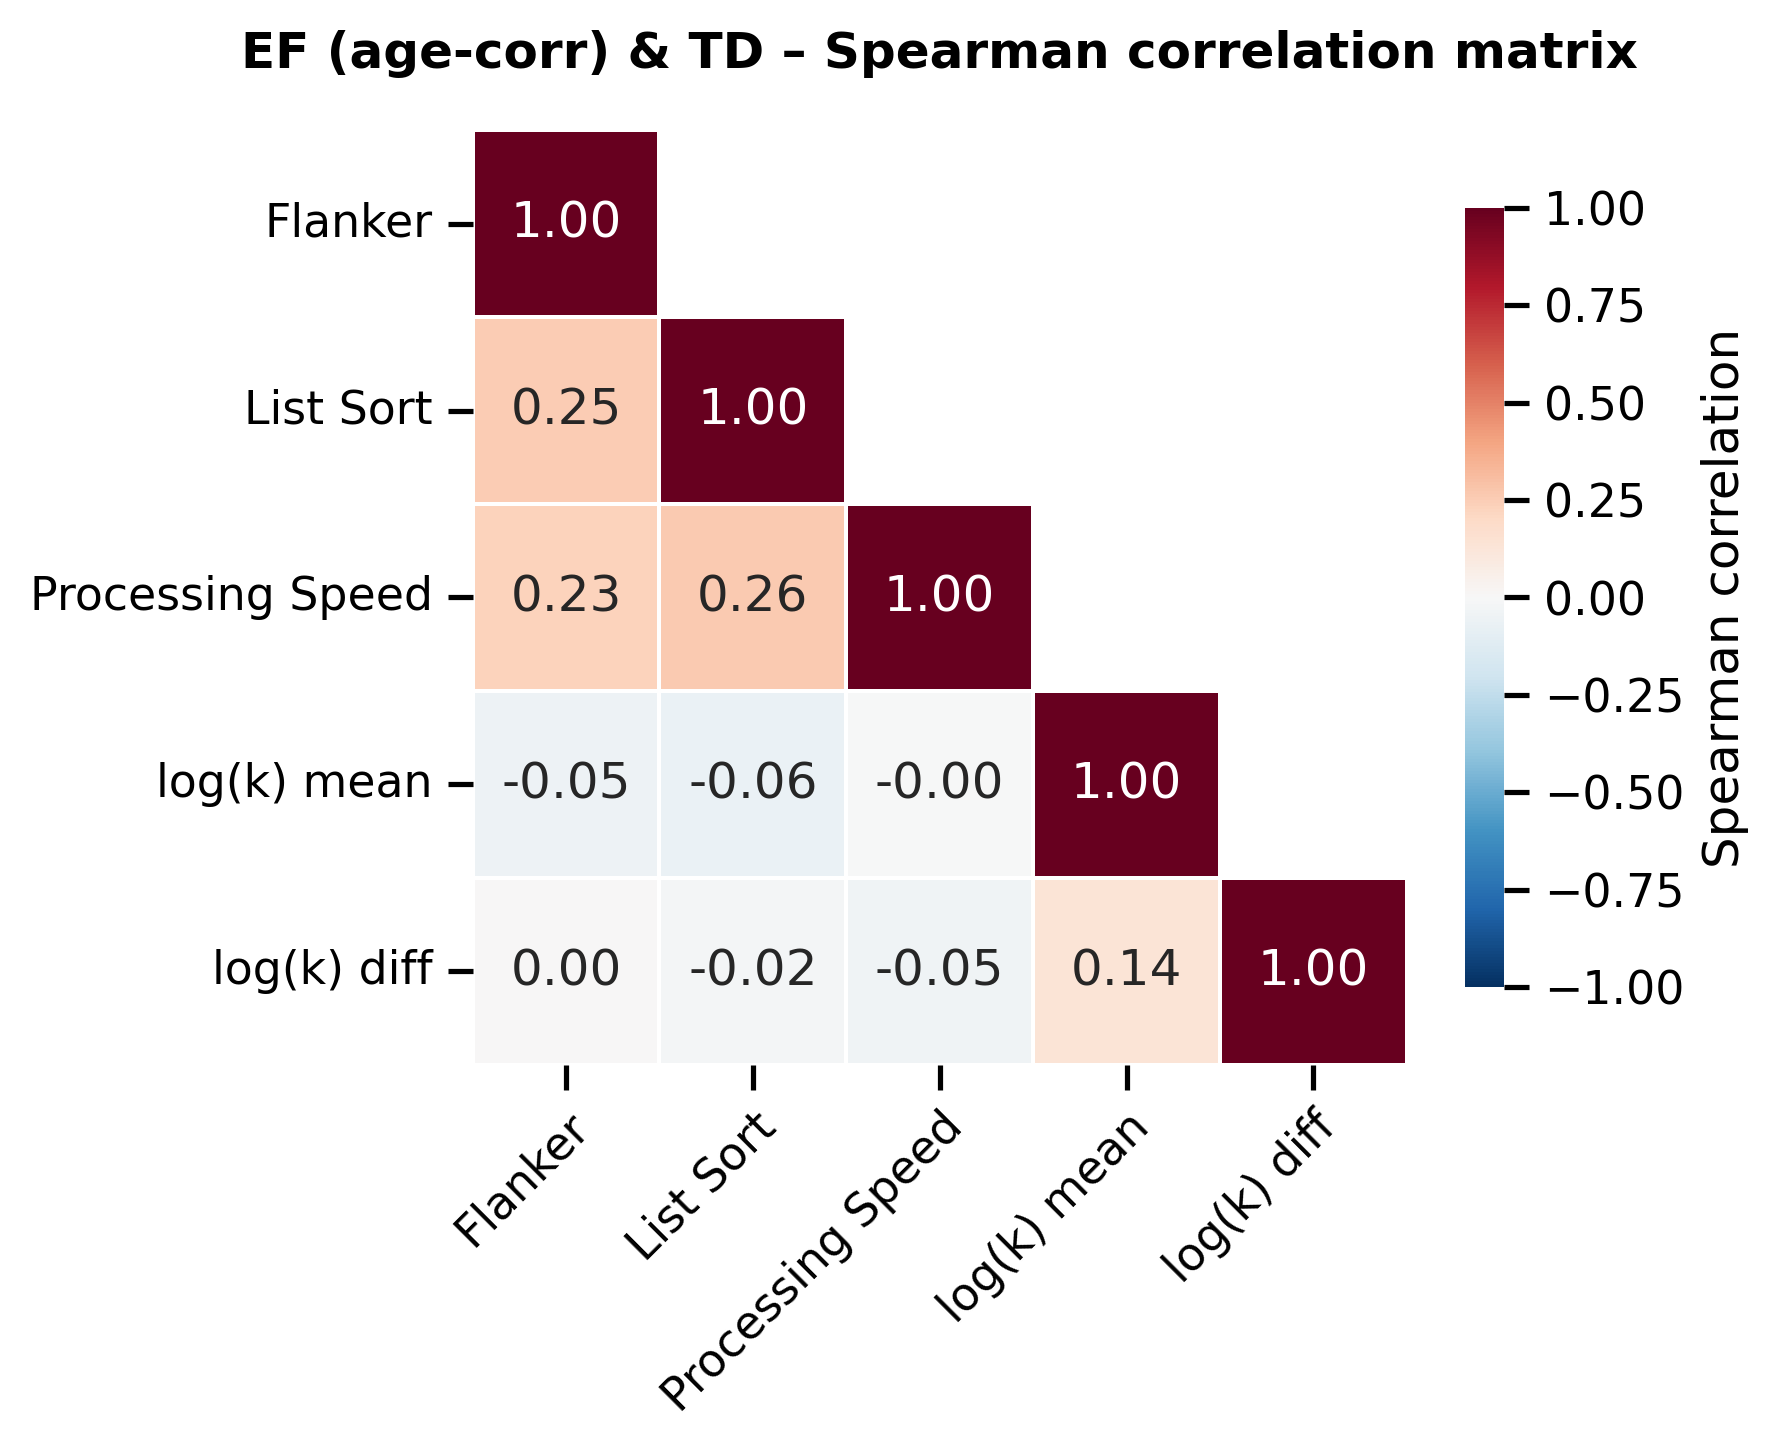

In [57]:
# Compute Spearman instead of Pearson
corr = sub.corr(method="spearman")
corr_clean = corr.rename(index=FEATURE_LABELS, columns=FEATURE_LABELS)

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_clean, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

sns.heatmap(
    corr_clean,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={
        "shrink": 0.8,
        "label": "Spearman correlation"
    },
    vmin=-1,
    vmax=1,
    ax=ax
)

ax.set_title("EF (age-corr) & TD – Spearman correlation matrix",
             fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel("")
ax.set_ylabel("")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0)

fig.tight_layout()

# Save correlation heatmap
corr_path = RESULTS_DIR / "spearmen_corr_heatmap.png"
plt.savefig(corr_path, dpi=300, bbox_inches='tight')
plt.show()

# Clustering

## Helpers (silhouette + PCA scatter + profiler)

In [7]:
# Reuse your scaled data Xp; build a 2D PCA projection for the scatter plots
pca2 = PCA(n_components=2, random_state=0).fit(Xp)
Z2 = pca2.transform(Xp)  # shape (n_samples, 2)

def plot_silhouette(name, labels, X_for_sil):
    """Silhouette bar plot; skips if fewer than 2 clusters."""
    labs = np.asarray(labels)
    uniq = np.unique(labs)
    if len(uniq) < 2:
        print(f"[{name}] Cannot compute silhouette (only {len(uniq)} cluster).")
        return

    sil_vals = silhouette_samples(X_for_sil, labs)
    sil_mean = silhouette_score(X_for_sil, labs)
    print(f"[{name}] Silhouette: {sil_mean:.3f}")

    y_lower = 10
    fig, ax = plt.subplots(figsize=(6, 3.2), dpi=200)
    for c in sorted(uniq):
        m = labs == c
        sv = np.sort(sil_vals[m])
        size_i = sv.size
        y_upper = y_lower + size_i
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sv, alpha=0.6)
        ax.text(-0.05, y_lower + 0.5*size_i, f"C{c}")
        y_lower = y_upper + 8
    ax.axvline(sil_mean, color="k", linestyle="--", linewidth=1)
    ax.set_title(f"Silhouette — {name}")
    ax.set_xlabel("Silhouette value")
    ax.set_ylabel("Samples")
    fig.tight_layout()
    plt.show()

def plot_pca_scatter(name, labels, Z2):
    """2D PCA scatter using Z2 (from Xp)."""
    labs = np.asarray(labels)
    fig, ax = plt.subplots(figsize=(5.2, 3.6), dpi=220)
    for c in np.unique(labs):
        m = labs == c
        ax.scatter(Z2[m, 0], Z2[m, 1], s=10, alpha=0.85, label=f"C{c}")
    ax.legend(frameon=True, fontsize=8)
    ax.set_title(f"PCA scatter — {name}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.grid(True, linewidth=0.3)
    fig.tight_layout()
    plt.show()

In [8]:
def profile_table_and_heatmap_mixed(
    df_original, labels, z_cols, age_col="Age", sex_col="Sex",
    title="Cluster profiles (Age yrs, Sex %M; EF/TD in population-z)", robust_q=0.95
):
    # Keep only labeled points (exclude noise = -1)
    dfc = df_original.copy()
    lab = np.asarray(labels)
    m = lab >= 0
    dfc = dfc.loc[m].copy()
    lab = lab[m]
    if len(np.unique(lab)) < 1:
        print("No non-noise clusters to profile.")
        return
    
    # Ensure Sex is numeric 0/1 for % display
    if sex_col in dfc.columns:
        dfc[sex_col] = pd.to_numeric(dfc[sex_col], errors="coerce")
    
    # Build population-z for z_cols (across all rows kept above)
    Zcols = dfc[z_cols]
    Z = (Zcols - Zcols.mean()) / Zcols.std(ddof=0)
    
    # Table of cluster means
    prof_age = dfc.groupby(lab)[age_col].mean().rename("Age (yrs)") if age_col in dfc else None
    prof_sex = (100 * dfc.groupby(lab)[sex_col].mean()).rename("Sex (%M)") if sex_col in dfc else None
    prof_z   = Z.groupby(lab).mean()
    
    parts = []
    if prof_age is not None: parts.append(prof_age)
    if prof_sex is not None: parts.append(prof_sex)
    parts.append(prof_z)
    prof = pd.concat(parts, axis=1).round(2)
    
    display(prof.style.set_caption(title))
    
    # Heatmap: use population-z values for EF/TD columns; Age/Sex shown but not used for color
    # Build a numeric matrix Mz aligned to prof's columns
    display_cols = prof.columns.tolist()
    # Construct a matrix in which non-z columns (Age/Sex) are anchored at 0 for color
    Mz = np.zeros_like(prof.values, dtype=float)
    for j, col in enumerate(display_cols):
        if col in ("Age (yrs)","Sex (%M)"):
            Mz[:, j] = 0.0  # no color influence
        else:
            # col exists in prof_z; already population-z means
            Mz[:, j] = prof[col].values
    
    # Robust symmetric color limits from |z|
    limit = np.nanpercentile(np.abs(Mz[:, ~np.isin(display_cols, ["Age (yrs)","Sex (%M)"])]), robust_q*100)
    vmax = max(1.0, float(limit))  # at least ±1
    norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)
    
    fig, ax = plt.subplots(figsize=(9.0, 3.8))
    im = ax.imshow(Mz, aspect="auto", cmap="RdBu_r", norm=norm)

    ax.set_yticks(range(Mz.shape[0])); ax.set_yticklabels([f"C{c}" for c in prof.index])
    ax.set_xticks(range(Mz.shape[1])); ax.set_xticklabels(display_cols, rotation=45, ha="right")

    # Cell text: Age as years, Sex as %, others as mean (original prof values)
    for i in range(Mz.shape[0]):
        for j, col in enumerate(display_cols):
            val = prof.iloc[i, j]
            if col == "Age (yrs)":
                txt = f"{val:.1f}"
            elif col == "Sex (%M)":
                txt = f"{val:.0f}%"
            else:
                txt = f"{val:.2f}"
            # Text color for contrast
            txt_color = "black" if abs(Mz[i, j]) < 0.6*vmax else "white"
            ax.text(j, i, txt, ha="center", va="center", color=txt_color, fontsize=8)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("EF/TD population z (Age/Sex not colored)")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [9]:
def profile(name, labels, z_cols):
    """Mixed-unit profile table + heatmap (your helper)."""
    print(f"[{name}] Cluster counts:")
    print(pd.Series(labels).value_counts().rename("count"))

    profile_table_and_heatmap_mixed(
        df_original=prof,          # original units for EF/TD + Age/Sex
        labels=labels,
        z_cols=z_cols,             # EF+TD as population-z in the heatmap color
        age_col="Age",
        sex_col="Sex",
        title=f"{name} — Cluster profiles (Age yrs, Sex %M; EF/TD population-z)",
        robust_q=0.95,
    )

## HDBSCAN

[HDBSCAN] min_cluster_size=40, min_samples=13 | noise=82.8% | silhouette=0.368
[HDBSCAN (mcs=40, ms=13)] Silhouette: 0.368


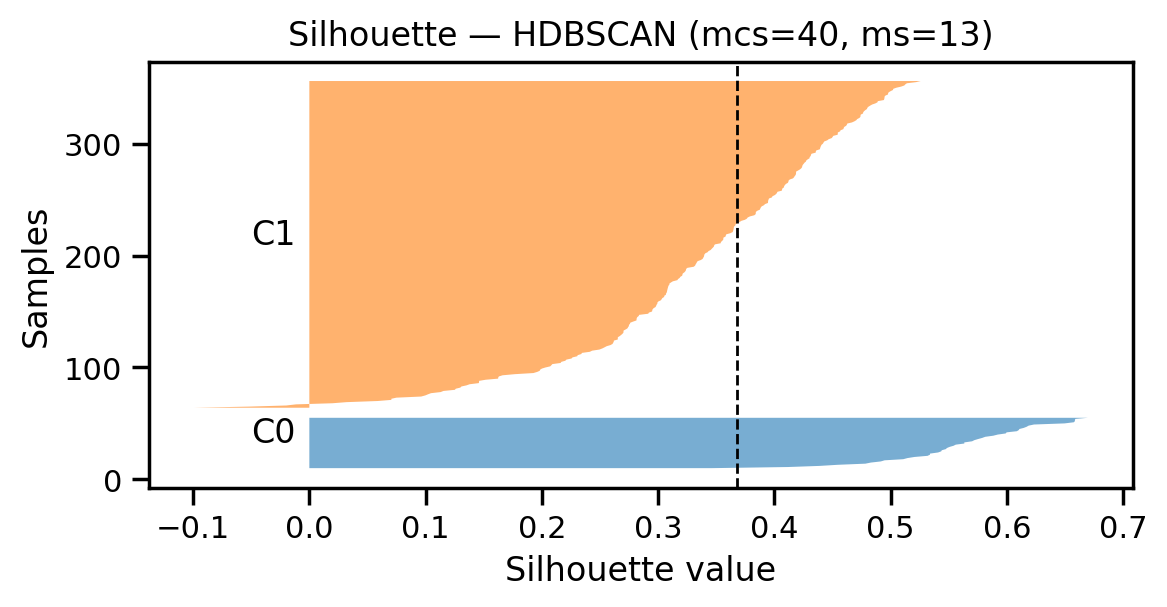

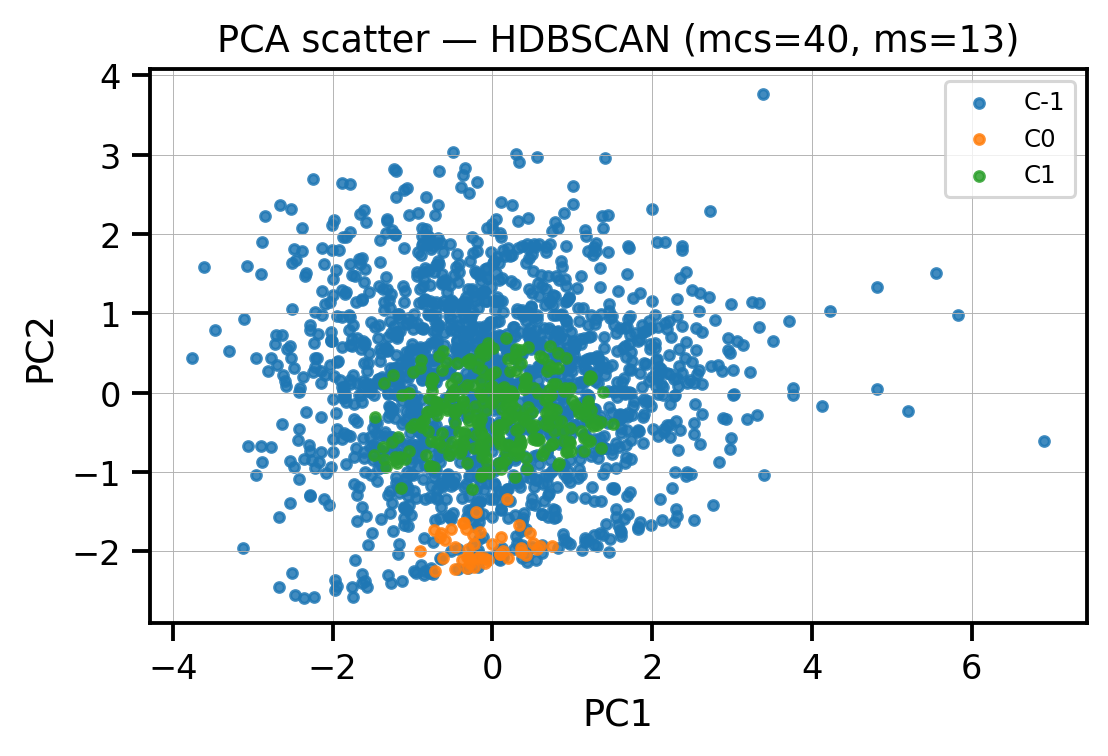

[HDBSCAN (mcs=40, ms=13)] Cluster counts:
-1    1636
 1     293
 0      46
Name: count, dtype: int64


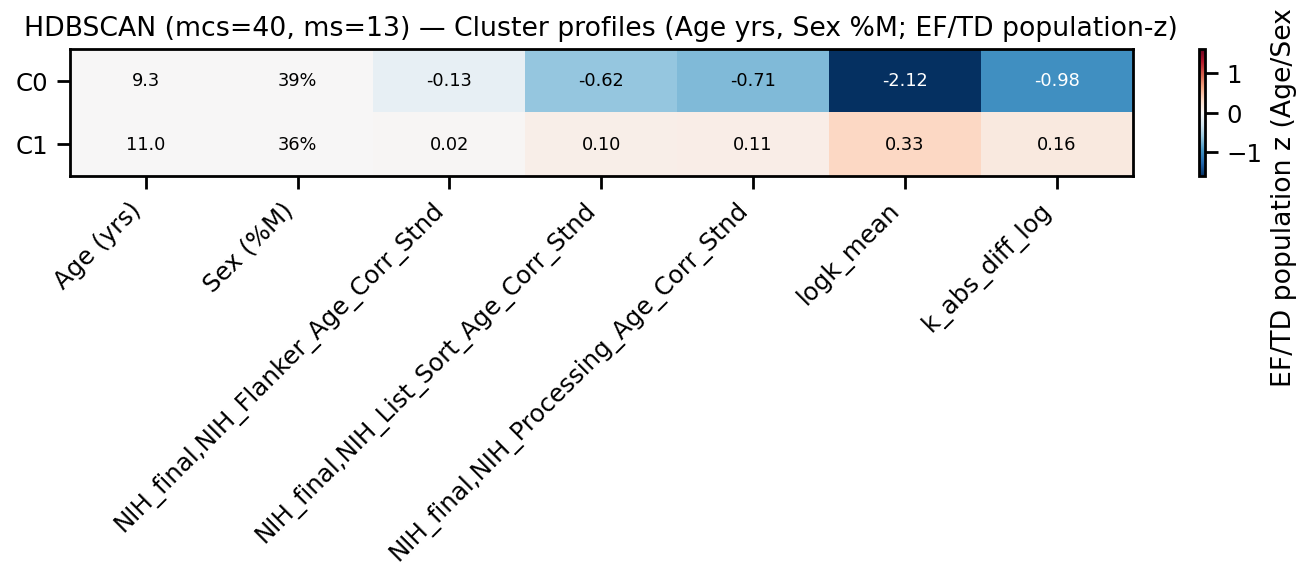

In [10]:
def hdbscan_best(X_scaled, min_cluster_sizes=(40, 60, 80, 120),
                 min_samples_factors=(1, 2, 3), metric="euclidean"):
    best = None
    for mcs in min_cluster_sizes:
        for msf in min_samples_factors:
            ms = max(1, mcs // msf)
            hdb = hdbscan.HDBSCAN(min_cluster_size=mcs,
                                  min_samples=ms,
                                  metric=metric)
            lab = hdb.fit_predict(X_scaled)
            m = lab >= 0  # exclude noise
            nclu = len(np.unique(lab[m]))
            score = silhouette_score(X_scaled[m], lab[m]) if (m.any() and nclu >= 2) else -np.inf
            cand = (score, mcs, ms, lab, hdb)
            if best is None or score > best[0]:
                best = cand
    return best  # (sil, mcs, ms, labels, model)

sil_hdb, mcs, ms, lab_hdb, hdb_model = hdbscan_best(Xp)
noise_pct = (lab_hdb == -1).mean() * 100
print(f"[HDBSCAN] min_cluster_size={mcs}, min_samples={ms} | noise={noise_pct:.1f}% | silhouette={sil_hdb:.3f}")

# Silhouette on clustered points only, PCA scatter on all (noise shown as its label)
m = lab_hdb >= 0
plot_silhouette(f"HDBSCAN (mcs={mcs}, ms={ms})", lab_hdb[m], Xp[m])
plot_pca_scatter(f"HDBSCAN (mcs={mcs}, ms={ms})", lab_hdb, Z2)

# Mixed-unit profiles (Age yrs, Sex %M; EF/TD colored by population-z)
profile(f"HDBSCAN (mcs={mcs}, ms={ms})", lab_hdb, z_cols=FEATURES)

## KMeans

[KMeans] k=4 | silhouette=0.184
[KMeans (k=4)] Silhouette: 0.184


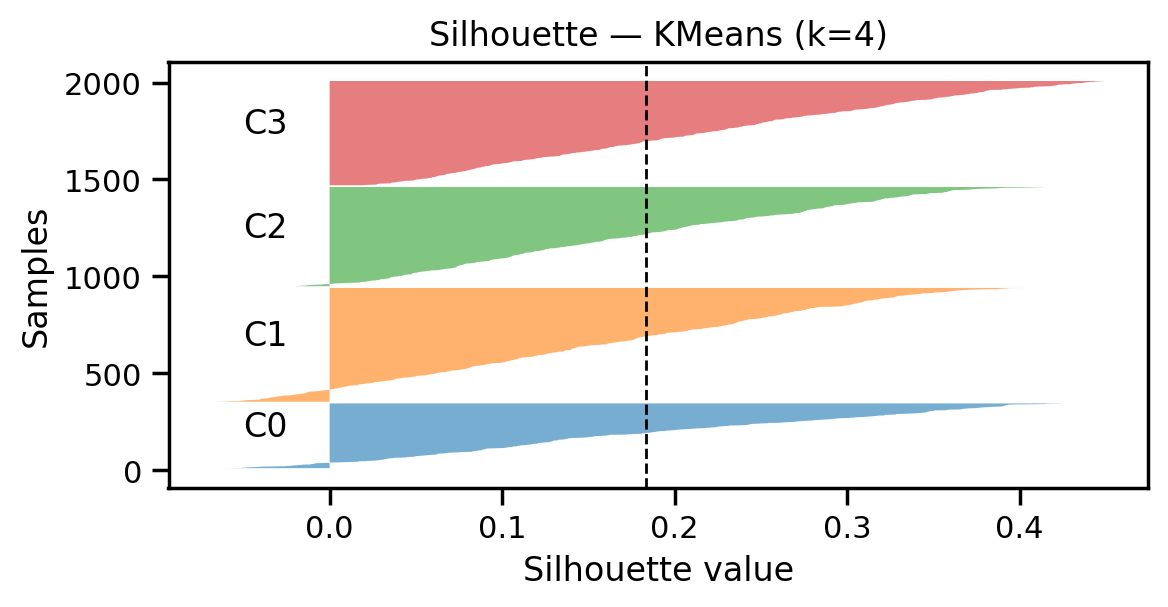

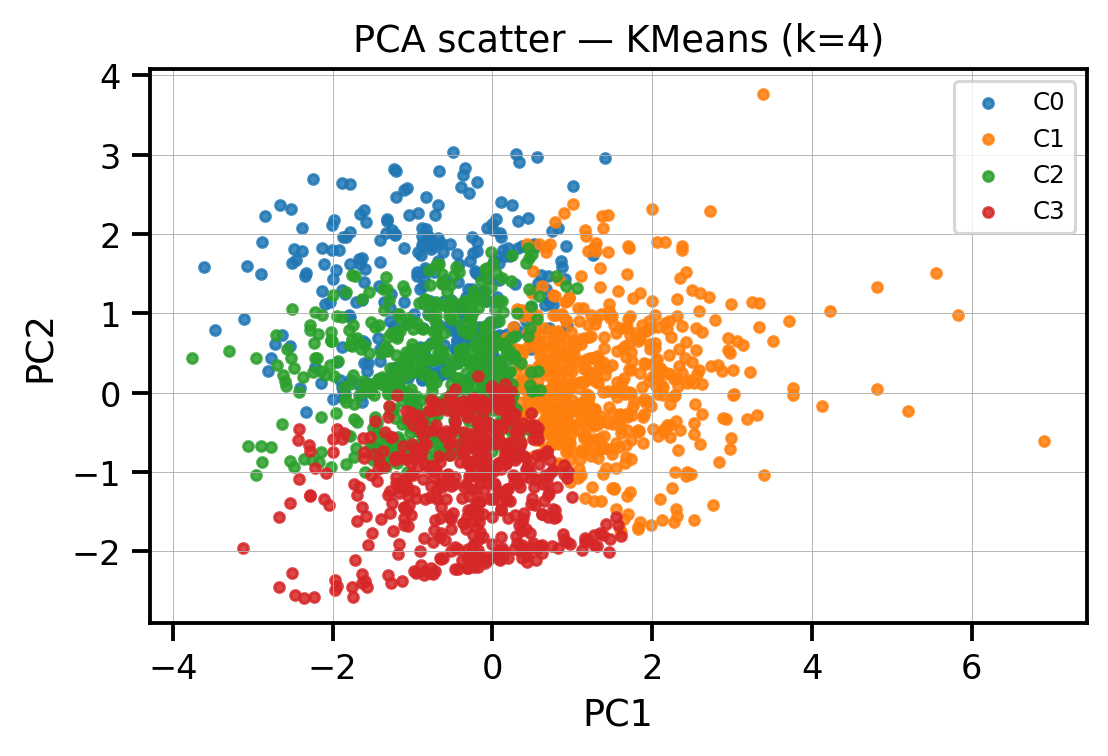

[KMeans (k=4)] Cluster counts:
1    588
3    539
2    513
0    335
Name: count, dtype: int64


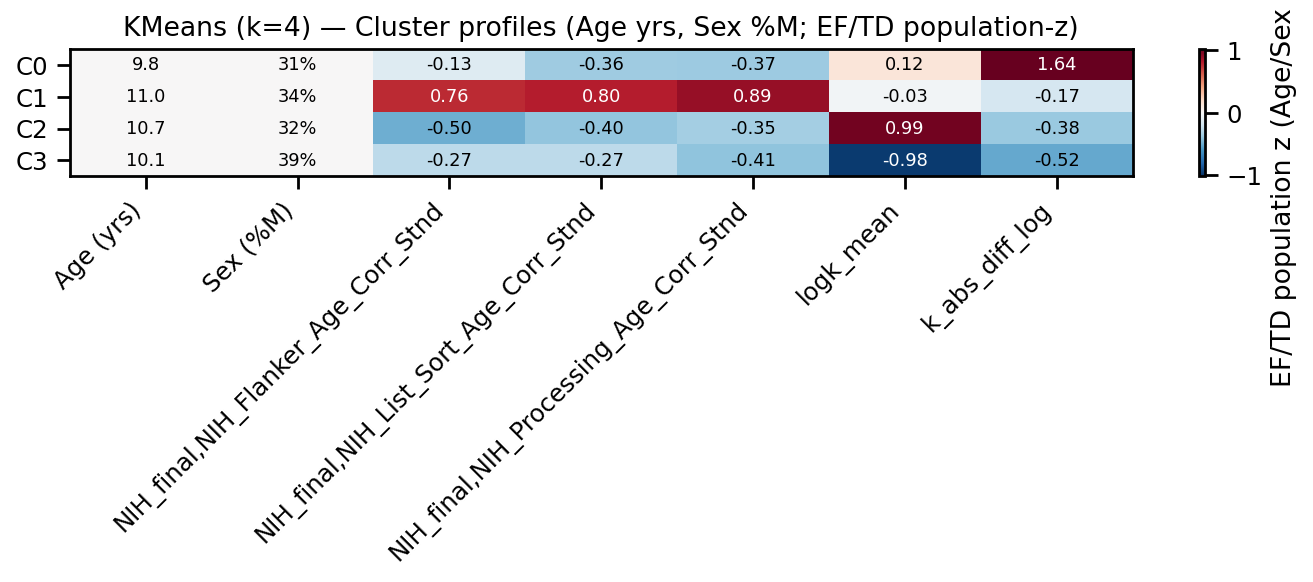

In [11]:
def kmeans_best(X_scaled, ks=(2, 3, 4, 5), n_init=20, random_state=0):
    best = None
    for k in ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        lab = km.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, lab) if len(np.unique(lab)) > 1 else -np.inf
        cand = (sil, k, lab, km)
        if best is None or sil > best[0]:
            best = cand
    return best  # (sil, k, labels, model)

sil_km, k_km, lab_km, km_model = kmeans_best(Xp, ks=(2,3,4,5))
print(f"[KMeans] k={k_km} | silhouette={sil_km:.3f}")

plot_silhouette(f"KMeans (k={k_km})", lab_km, Xp)
plot_pca_scatter(f"KMeans (k={k_km})", lab_km, Z2)
profile(f"KMeans (k={k_km})", lab_km, z_cols=FEATURES)

## Gaussian Mixture (GMM)

[GMM] Best k=2 with silhouette=0.143
[GMM (k=2)] Silhouette: 0.143


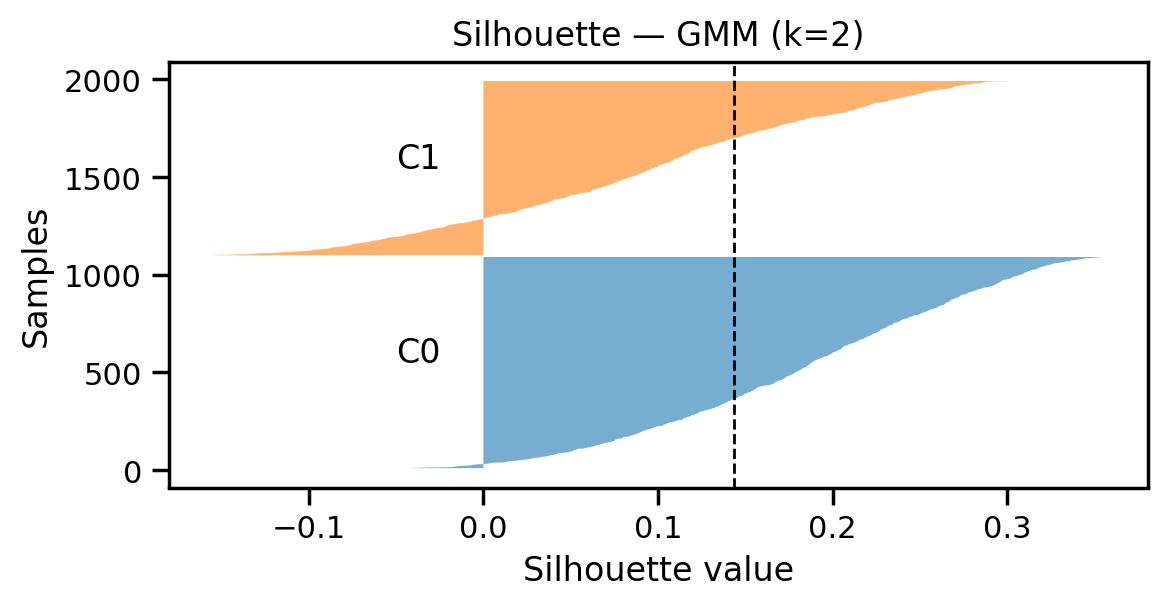

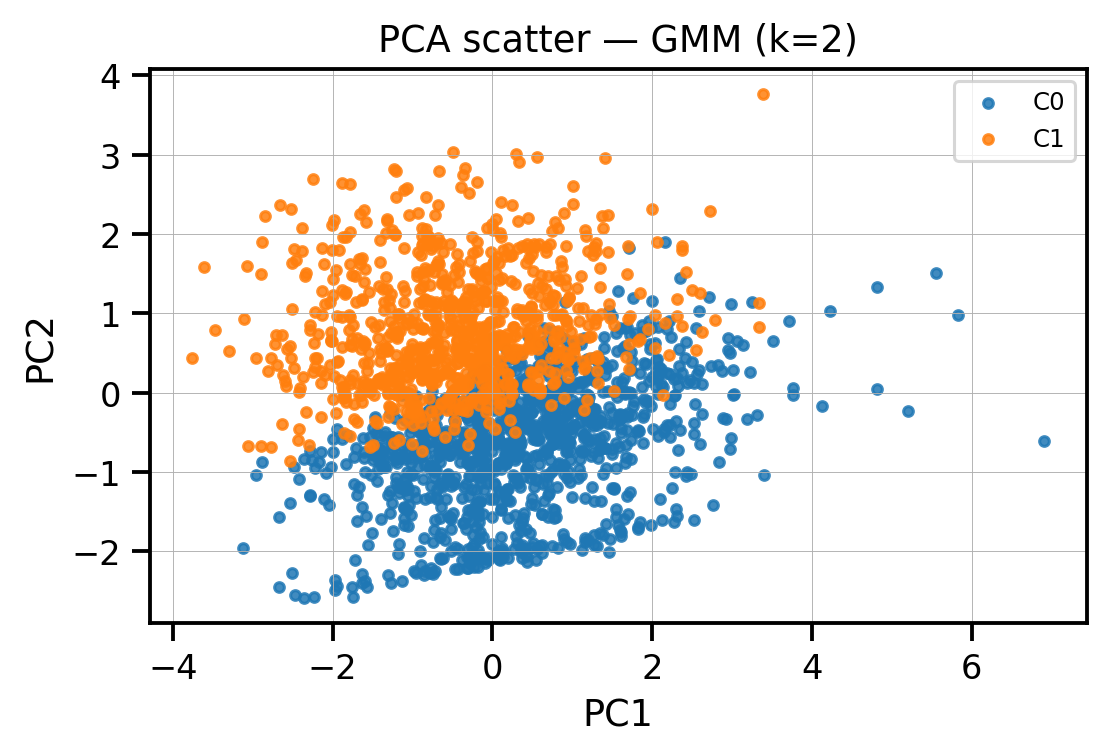

[GMM (k=2)] Cluster counts:
0    1082
1     893
Name: count, dtype: int64


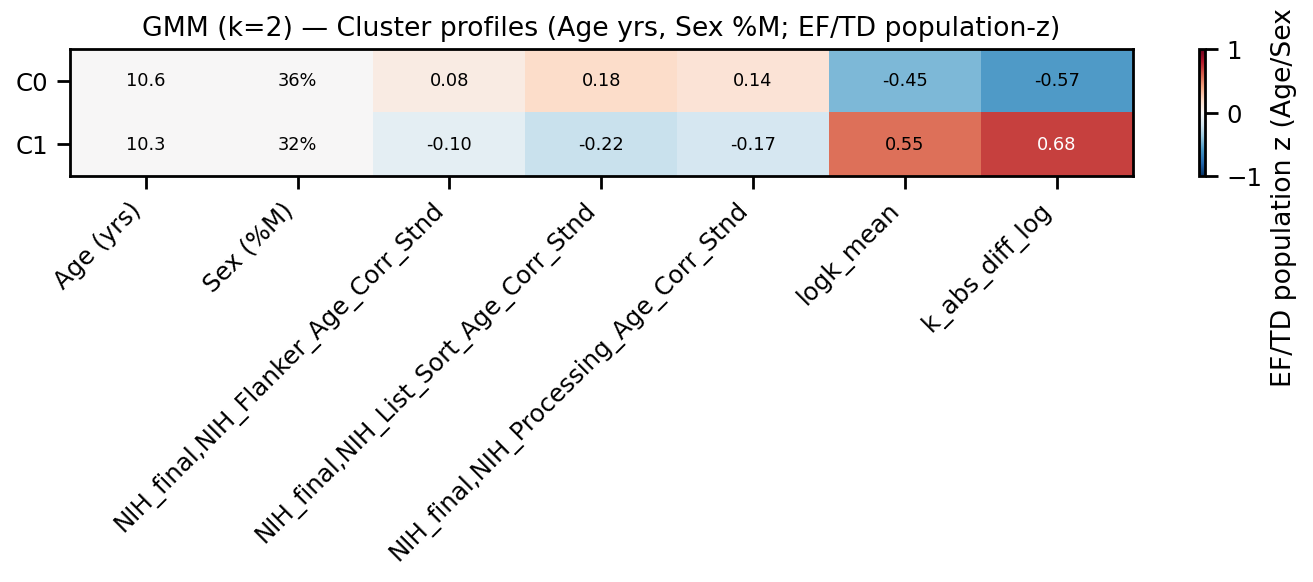

In [12]:
def run_gmm(X_scaled, ks=(2,3,4,5), random_state=0):
    best = None
    for k in ks:
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state)
        lab = gmm.fit_predict(X_scaled)
        if len(np.unique(lab)) < 2:
            score = -np.inf
        else:
            score = silhouette_score(X_scaled, lab)
        best = max(best, (score, k, lab), key=lambda t: t[0]) if best else (score, k, lab)
    return best  # (sil, k, labels)

sil_gmm, k_gmm, lab_gmm = run_gmm(Xp, ks=(2,3,4,5))
print(f"[GMM] Best k={k_gmm} with silhouette={sil_gmm:.3f}")

plot_silhouette(f"GMM (k={k_gmm})", lab_gmm, Xp)
plot_pca_scatter(f"GMM (k={k_gmm})", lab_gmm, Z2)
profile(f"GMM (k={k_gmm})", lab_gmm, z_cols=FEATURES)

## Agglomerative (Ward)

[Agglomerative] Best k=4 with silhouette=0.127
[Agglomerative (k=4)] Silhouette: 0.127


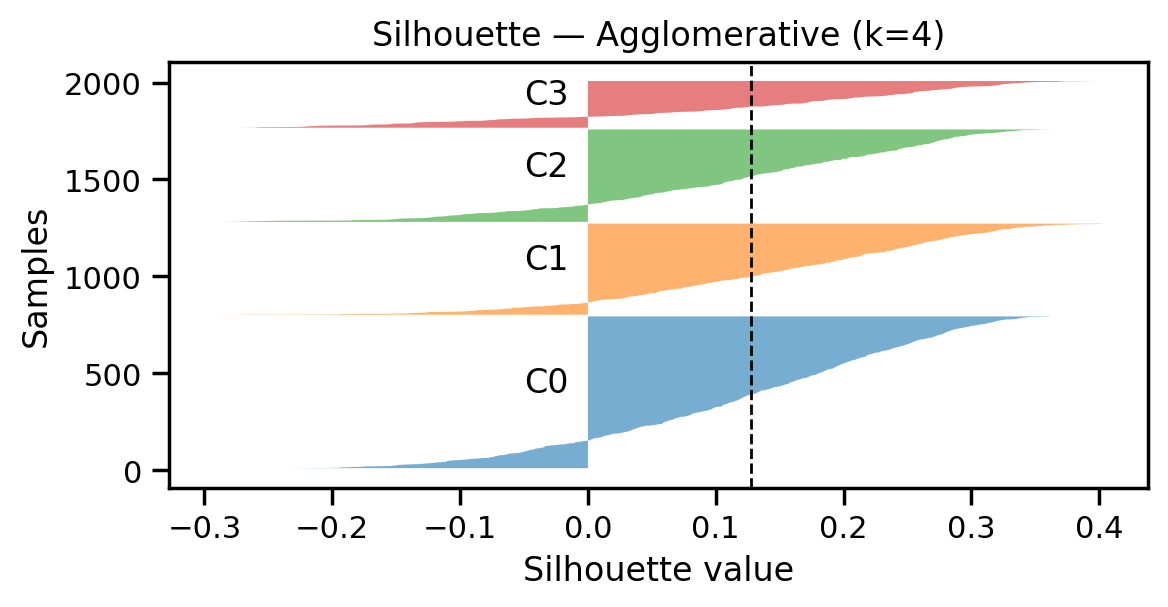

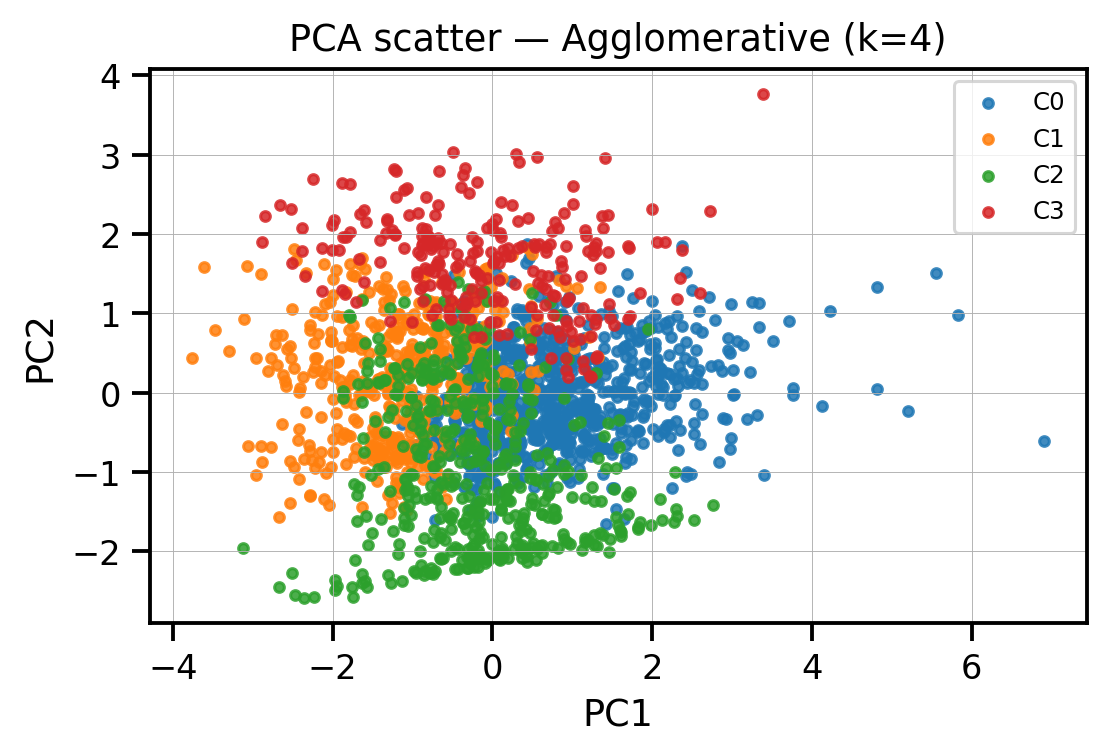

[Agglomerative (k=4)] Cluster counts:
0    784
2    478
1    471
3    242
Name: count, dtype: int64


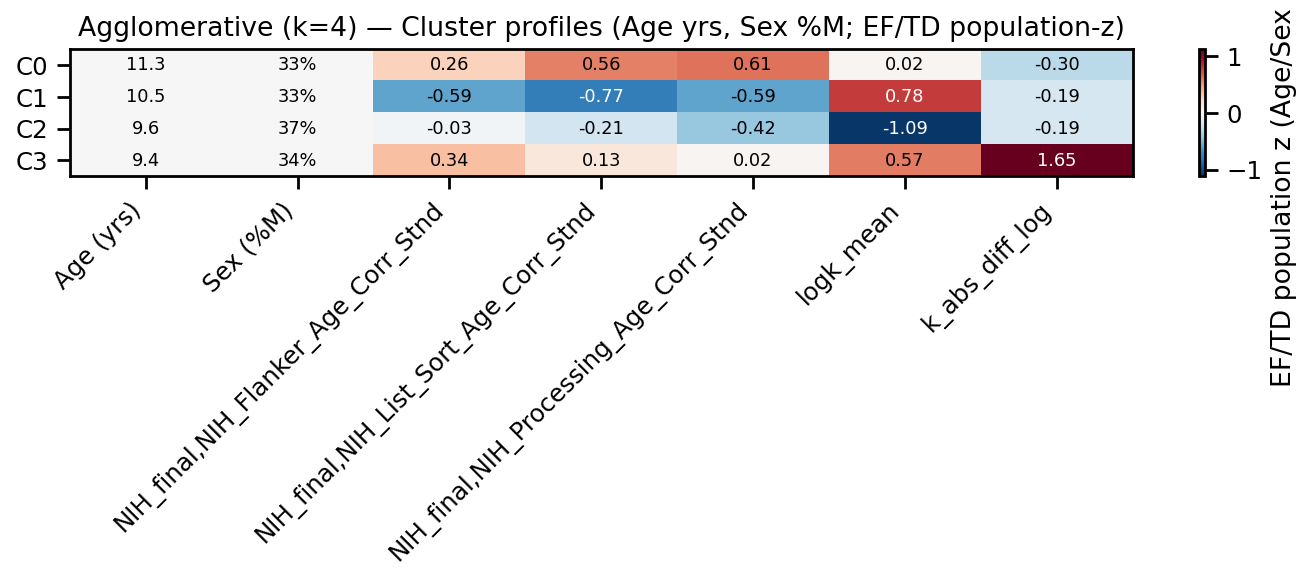

In [13]:
def run_agg(X_scaled, ks=(2,3,4,5)):
    best = None
    for k in ks:
        lab = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X_scaled)
        if len(np.unique(lab)) < 2:
            score = -np.inf
        else:
            score = silhouette_score(X_scaled, lab)
        best = max(best, (score, k, lab), key=lambda t: t[0]) if best else (score, k, lab)
    return best

sil_agg, k_agg, lab_agg = run_agg(Xp, ks=(2,3,4,5))
print(f"[Agglomerative] Best k={k_agg} with silhouette={sil_agg:.3f}")

plot_silhouette(f"Agglomerative (k={k_agg})", lab_agg, Xp)
plot_pca_scatter(f"Agglomerative (k={k_agg})", lab_agg, Z2)
profile(f"Agglomerative (k={k_agg})", lab_agg, z_cols=FEATURES)

## Spectral Clustering on a k-NN graph

[Spectral(KNN graph)] Best k=4, n_neighbors=20, silhouette=0.178
[Spectral KNN (k=4, nn=20)] Silhouette: 0.178


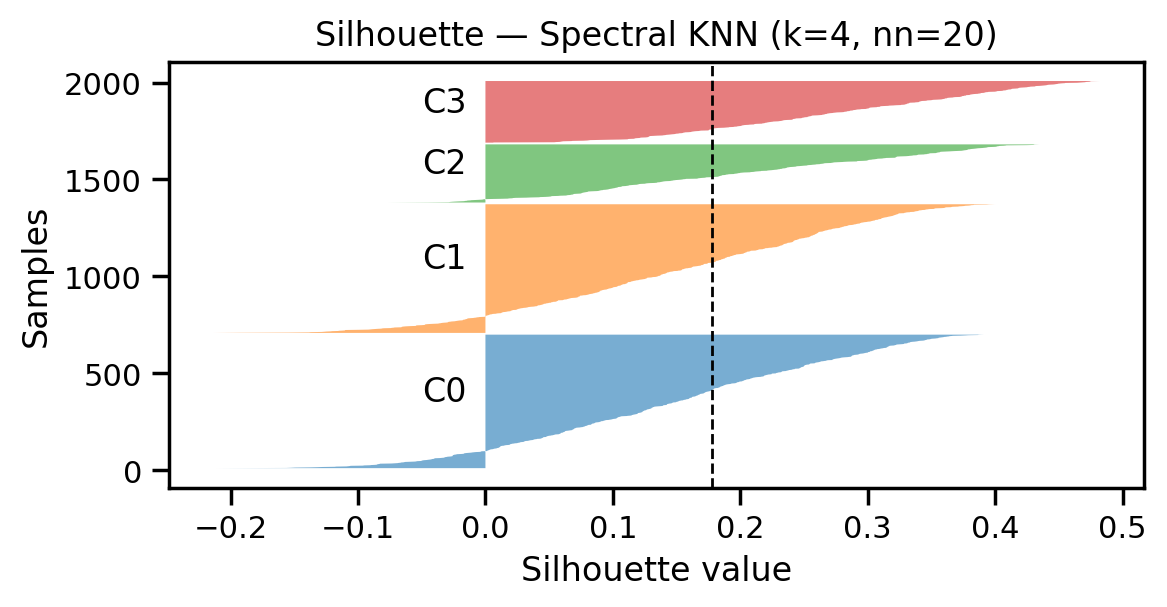

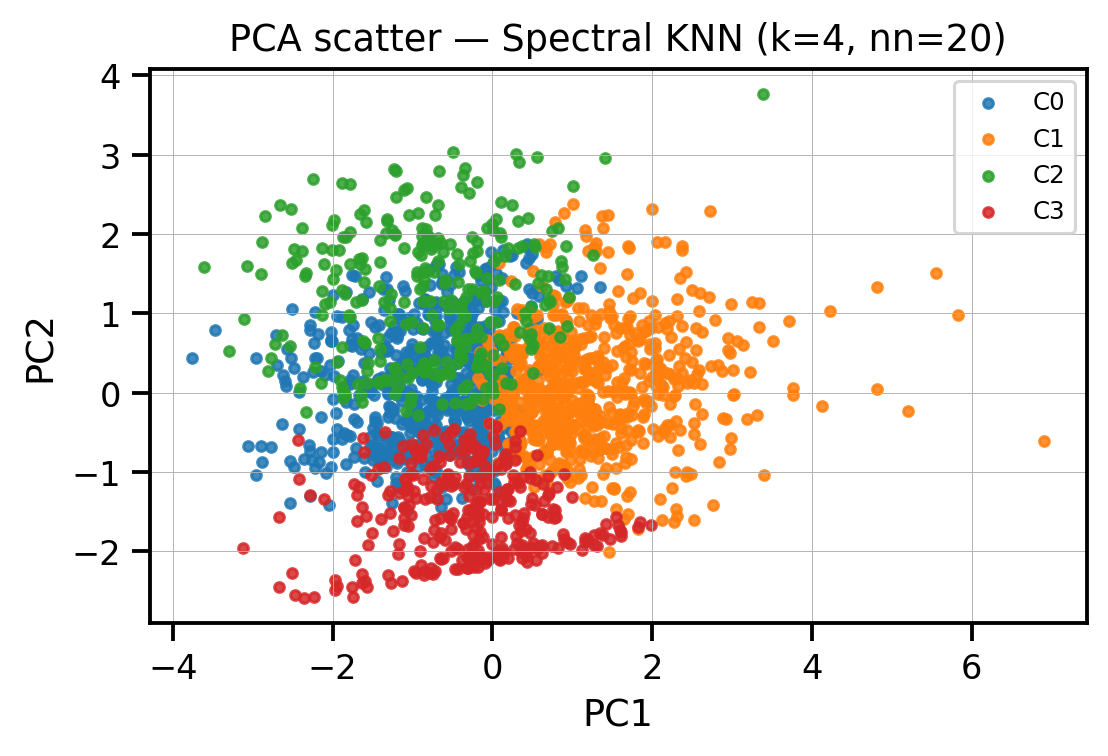

[Spectral KNN (k=4, nn=20)] Cluster counts:
0    690
1    665
3    319
2    301
Name: count, dtype: int64


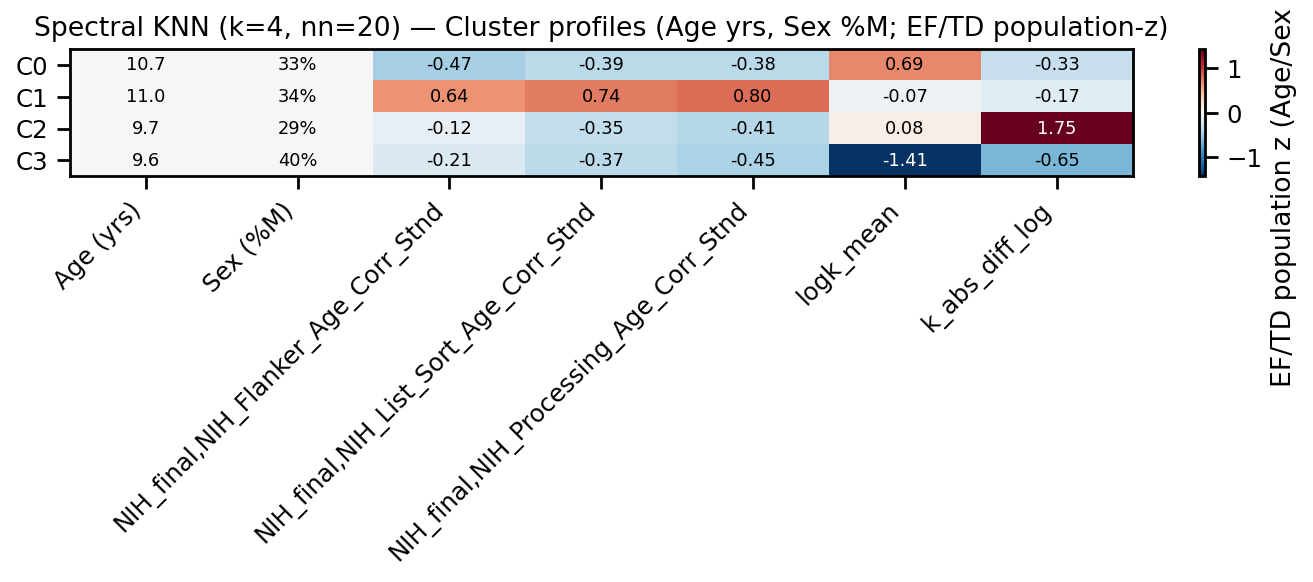

In [14]:
def run_spectral_knn(X_scaled, ks=(2,3,4,5), neighbors=(10,15,20), random_state=0):
    best = None
    for n_nb in neighbors:
        for k in ks:
            # Spectral can occasionally return a single cluster; catch/skip
            try:
                spec = SpectralClustering(
                    n_clusters=k,
                    affinity="nearest_neighbors",
                    n_neighbors=n_nb,
                    assign_labels="kmeans",
                    random_state=random_state,
                )
                lab = spec.fit_predict(X_scaled)
                if len(np.unique(lab)) < 2:
                    score = -np.inf
                else:
                    score = silhouette_score(X_scaled, lab)
                cand = (score, k, n_nb, lab)
                best = max(best, cand, key=lambda t: t[0]) if best else cand
            except Exception as e:
                print(f"[Spectral] Skipped k={k}, n_neighbors={n_nb}: {e}")
                continue
    return best  # (sil, k, n_neighbors, labels)

sil_sp, k_sp, nn_sp, lab_sp = run_spectral_knn(Xp, ks=(2,3,4,5), neighbors=(10,15,20))
print(f"[Spectral(KNN graph)] Best k={k_sp}, n_neighbors={nn_sp}, silhouette={sil_sp:.3f}")

plot_silhouette(f"Spectral KNN (k={k_sp}, nn={nn_sp})", lab_sp, Xp)
plot_pca_scatter(f"Spectral KNN (k={k_sp}, nn={nn_sp})", lab_sp, Z2)
profile(f"Spectral KNN (k={k_sp}, nn={nn_sp})", lab_sp, z_cols=FEATURES)

## Helper

In [15]:
def impute_original_units(X: pd.DataFrame) -> pd.DataFrame:
    """Median-impute numeric columns; returns DataFrame in original units."""
    imp = SimpleImputer(strategy="median")
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
    return X_imp

def plot_perm_importance(df, features, labels, title):
    lab = pd.Series(labels, index=df.index).dropna()
    X = df.loc[lab.index, features].apply(pd.to_numeric, errors="coerce")
    Xtr, Xte, ytr, yte = train_test_split(X, lab, test_size=0.3, random_state=0, stratify=lab)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, multi_class="multinomial"))
    ]).fit(Xtr, ytr)

    pi = permutation_importance(pipe, Xte, yte, n_repeats=20, random_state=0)
    imp = pd.Series(pi.importances_mean, index=features).sort_values()

    acc = pipe.score(Xte, yte)
    plt.figure(figsize=(6.2, 3.6), dpi=200)
    imp.plot.barh()
    plt.title(f"{title} — Permutation importance (acc={acc:.2f})")
    plt.xlabel("Importance (mean Δ accuracy)")
    plt.tight_layout(); plt.show()

# Method Selection

## 0) Gather clustering labels

In [16]:

labels_dict = {}
def add_labels(name, arr, treat_noise_as_invalid=False):
    if arr is None: return
    arr = np.asarray(arr)
    if arr.ndim != 1 or len(arr) != len(Xp): return
    valid = np.ones(len(arr), dtype=bool)
    if treat_noise_as_invalid:
        valid &= (arr >= 0)
    labels_dict[name] = {"labels": arr, "valid": valid}

add_labels("KMeans",         globals().get("lab_km"))
add_labels("GMM",            globals().get("lab_gmm"))
add_labels("Agglomerative",  globals().get("lab_agg"))
add_labels("HDBSCAN",        globals().get("lab_hdb"), treat_noise_as_invalid=True)
add_labels("Spectral",       globals().get("lab_sp"))

if not labels_dict:
    raise RuntimeError("No clustering labels found. Define lab_km/lab_gmm/lab_agg/lab_hdb/lab_sp first.")


## 1) Per-method silhouette (on the subset each method considers valid)

In [17]:

def safe_silhouette(X, y, valid_mask):
    yv = y[valid_mask]
    if len(np.unique(yv)) < 2: 
        return np.nan
    return silhouette_score(X[valid_mask], yv)

for name, d in labels_dict.items():
    d["silhouette"] = safe_silhouette(Xp, d["labels"], d["valid"])
    # effective number of clusters (excluding noise for HDBSCAN)
    yv = d["labels"][d["valid"]]
    d["n_clusters"] = len(np.unique(yv))

## 2) Pairwise Adjusted Rand Index 
- "Agreement" between this method’s labels and the labels from the other methods, then averaged.
- Higher ⇒ this partition is more consistent with the others.

In [18]:

meths = list(labels_dict.keys())
ari_matrix = pd.DataFrame(np.nan, index=meths, columns=meths)
for a in meths:
    for b in meths:
        va = labels_dict[a]["valid"]; la = labels_dict[a]["labels"]
        vb = labels_dict[b]["valid"]; lb = labels_dict[b]["labels"]
        m = va & vb
        if m.sum() >= 2 and len(np.unique(la[m]))>1 and len(np.unique(lb[m]))>1:
            ari_matrix.loc[a,b] = adjusted_rand_score(la[m], lb[m])

mean_ari = ari_matrix.replace(1.0, np.nan).mean(axis=1)  # exclude perfect self-ARI


## 3) Interpretability & demographic dominance
- η² for EF/TD (higher median = clearer separation on mechanism)
    - Using the median avoids one feature with an extreme η² dominating the summary
    - reflects the “typical” separation on EF/TD.
- η² for Age (want smaller than EF/TD median)
- Cramér’s V for Sex (want small)

In [19]:

def eta_squared_num(y, x):
    # y: numeric vector; x: cluster labels
    df_ = pd.DataFrame({"y": y, "x": x}).dropna()
    if df_.empty or df_["x"].nunique()<2: return np.nan
    grand = df_["y"].mean()
    ss_tot = ((df_["y"] - grand)**2).sum()
    ss_between = sum([(g["y"].count() * (g["y"].mean() - grand)**2) for _, g in df_.groupby("x")])
    return float(ss_between/ss_tot) if ss_tot>0 else np.nan

def _cramers_v_bias_corrected(ct: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.to_numpy().sum()
    if n == 0:
        return np.nan
    r, k = ct.shape
    phi2 = chi2 / n
    # Bergsma (2013) small-sample correction
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else np.nan

def cramers_v_from_series(labels, sex_series) -> float:
    """
    Calculate Cramér's V between cluster labels and sex (FIXED VERSION).
    
    Handles numeric Sex values (0, 1, 0.0, 1.0) properly.
    """
    # Align by position
    lab = pd.Series(labels).reset_index(drop=True)
    s = pd.Series(sex_series).reset_index(drop=True)
    
    # Remove missing values first
    valid = lab.notna() & s.notna()
    lab = lab[valid]
    s = s[valid]
    
    if len(lab) < 10:  # Minimum sample size
        return np.nan
    
    # FIX: Convert to numeric first, THEN map
    s = pd.to_numeric(s, errors='coerce')
    sex_map = {0: "female", 1: "male", 0.0: "female", 1.0: "male"}
    s = s.map(sex_map)
    
    # Fallback for string formats
    if s.isna().any():
        s_orig = pd.Series(sex_series).reset_index(drop=True)[valid]
        s_fallback = (s_orig.astype(str).str.strip().str.lower()
                      .replace({"m": "male", "f": "female", 
                               "male": "male", "female": "female",
                               "0": "female", "1": "male",
                               "0.0": "female", "1.0": "male"}))
        s = s.fillna(s_fallback)
    
    # Final validity check
    ok = s.isin(["male", "female"]) & lab.notna()
    lab = lab[ok]
    s = s[ok]
    
    if lab.nunique() < 2 or s.nunique() < 2 or len(lab) < 10:
        return np.nan
    
    ct = pd.crosstab(lab, s)
    return float(_cramers_v_bias_corrected(ct))



## 4) Summary

In [20]:
summary_rows = []
for name, d in labels_dict.items():
    m = d["valid"]                 # boolean mask for this method
    y = d["labels"][m]             # labels for those rows

    # η² across EF+TD features (median)
    ef_td_eta2 = [eta_squared_num(df.loc[m, col], y) for col in FEATURES]
    median_eta2 = float(np.nanmedian(ef_td_eta2))

    eta2_age = eta_squared_num(df.loc[m, "Age"], y) if "Age" in df.columns else np.nan
    cv_sex   = cramers_v_from_series(y, prof.loc[m, "Sex"]) if "Sex" in prof.columns else np.nan

    summary_rows.append({
        "method": name,
        "n_clusters": d["n_clusters"],
        "n_points_used": int(m.sum()),
        "silhouette": d["silhouette"],
        "mean_ARI": mean_ari.get(name, np.nan),
        "median_eta2_EF_TD": median_eta2,
        "eta2_age": eta2_age,
        "cramerV_sex": cv_sex,
    })

summary = pd.DataFrame(summary_rows).sort_values(
    ["silhouette","mean_ARI"], ascending=False
)

In [21]:
display(summary.style.format({
    "silhouette": "{:.3f}",
    "mean_ARI": "{:.3f}",
    "median_eta2_EF_TD": "{:.3f}",
    "eta2_age": "{:.3f}",
    "cramerV_sex": "{:.3f}",
}))

- `n_clusters`: how many clusters that method produced.
- `n_points_used`: how many participants were actually clustered.
    - Only HDBSCAN can mark points as noise (unassigned), so its count (339) is much smaller than 1,975
- `silhouette`: cohesion/separation of the clusters (−1 to 1; higher is better).
    - HDBSCAN looks best here, but it’s on a much smaller, cleaner subset; silhouettes aren’t strictly comparable when the sample sizes differ that much.
- `mean_ARI`: “agreement” with other partitions.
    - Spectral and Agglomerative show the best cross-method agreement; KMeans is decent; GMM and HDBSCAN agree less with the rest (HDBSCAN partly because it drops many points).
- `median_eta2_EF_TD`: typical effect size (η²) for EF/TD features when comparing clusters.
    - KMeans and Spectral show the strongest EF/TD separation.
- `eta2_age`: effect size for Age differences across clusters

## 5) Choose winner:
- silhouette within 90% of the best
- not dominated by demographics:
    - EF/TD median  $η² >= 2×$ max(eta2_age, cramerV_sex^2 approx effect)
    - Sex association modest (Cramér’s V <= 0.3)

In [22]:
best_sil = summary["silhouette"].max(skipna=True)
def dominance_pass(row):
    dem = np.nanmax([row["eta2_age"], (row["cramerV_sex"] or 0)**2])
    return (row["median_eta2_EF_TD"] >= 2.0 * dem) and (row["cramerV_sex"] <= 0.30)

cands = summary[
    (summary["silhouette"] >= 0.90*best_sil) &
    summary.apply(dominance_pass, axis=1)
].copy()

if cands.empty:
    # fall back: just take top silhouette that isn't trivially demographic
    cands = summary.head(1)

chosen = cands.sort_values(["mean_ARI","median_eta2_EF_TD","silhouette"],
                           ascending=[False, False, False]).head(1)
display(chosen)

method  n_clusters  n_points_used  silhouette  mean_ARI  \
3  HDBSCAN           2            339    0.367953  0.145011   

   median_eta2_EF_TD  eta2_age  cramerV_sex  
3           0.080147  0.037081          0.0

In [23]:
chosen_name = chosen.iloc[0]["method"]
chosen_mask = labels_dict[chosen_name]["valid"]
chosen_labels = labels_dict[chosen_name]["labels"]

print(f"\nChosen partition: {chosen_name} | k={labels_dict[chosen_name]['n_clusters']} | "
      f"sil={labels_dict[chosen_name]['silhouette']:.3f}")


Chosen partition: HDBSCAN | k=2 | sil=0.368


# Improved Method Selection

## Cluster Evaluator

In [24]:
def eta_squared_num(y: pd.Series, labels: np.ndarray) -> float:
    df_ = pd.DataFrame({"y": pd.to_numeric(y, errors="coerce"), "lab": labels}).dropna()
    if df_["lab"].nunique() < 2:
        return np.nan
    grand = df_["y"].mean()
    ss_tot = ((df_["y"] - grand)**2).sum()
    if ss_tot == 0:
        return np.nan
    ss_between = sum(len(g)*(g["y"].mean() - grand)**2 for _, g in df_.groupby("lab"))
    return float(ss_between / ss_tot)

def _cramers_v_bias_corrected(ct: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.to_numpy().sum()
    if n == 0: return np.nan
    r, k = ct.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else np.nan

def cramers_v_from_series(labels, sex_series) -> float:
    """
    Calculate Cramér's V between cluster labels and sex (FIXED VERSION).
    
    Handles numeric Sex values (0, 1, 0.0, 1.0) properly.
    """
    # Align by position
    lab = pd.Series(labels).reset_index(drop=True)
    s = pd.Series(sex_series).reset_index(drop=True)
    
    # Remove missing values first
    valid = lab.notna() & s.notna()
    lab = lab[valid]
    s = s[valid]
    
    if len(lab) < 10:  # Minimum sample size
        return np.nan
    
    # FIX: Convert to numeric first, THEN map
    s = pd.to_numeric(s, errors='coerce')
    sex_map = {0: "female", 1: "male", 0.0: "female", 1.0: "male"}
    s = s.map(sex_map)
    
    # Fallback for string formats
    if s.isna().any():
        s_orig = pd.Series(sex_series).reset_index(drop=True)[valid]
        s_fallback = (s_orig.astype(str).str.strip().str.lower()
                      .replace({"m": "male", "f": "female", 
                               "male": "male", "female": "female",
                               "0": "female", "1": "male",
                               "0.0": "female", "1.0": "male"}))
        s = s.fillna(s_fallback)
    
    # Final validity check
    ok = s.isin(["male", "female"]) & lab.notna()
    lab = lab[ok]
    s = s[ok]
    
    if lab.nunique() < 2 or s.nunique() < 2 or len(lab) < 10:
        return np.nan
    
    ct = pd.crosstab(lab, s)
    return float(_cramers_v_bias_corrected(ct))

def sil_with_coverage(X, labels):
    if len(np.unique(labels)) < 2:
        return np.nan, 0.0, np.nan
    sil = silhouette_score(X, labels)
    cov = len(labels) / X.shape[0]
    return sil, cov, sil*cov

In [25]:
class ClusteringEvaluator:
    def __init__(self, X_scaled: np.ndarray, df_original: pd.DataFrame, feature_cols: List[str]):
        self.X = X_scaled
        self.df = df_original
        self.feature_cols = feature_cols
        self.results: Dict[str, dict] = {}

    def evaluate(self, name: str, labels: np.ndarray, valid_mask: np.ndarray,
                 fit_predict_fn: Callable[[np.ndarray], np.ndarray]) -> dict:
        # keep only valid (non-noise) rows for metrics
        m = valid_mask.astype(bool)
        Xc = self.X[m]
        dfc = self.df.iloc[m]
        labs = np.asarray(labels)[m]

        n_clusters = len(np.unique(labs))
        sil, cov, sil_cov = sil_with_coverage(Xc, labs)

        res = {
            "method": name,
            "n_clusters": n_clusters,
            "n_points": int(m.sum()),
            "noise_pct": 100.0*(~m).mean(),
            "silhouette": sil,
            "coverage": cov,
            "silhouette_x_coverage": sil_cov,
            "stability": self._bootstrap_stability(m, labs, fit_predict_fn),
            "feature_separation_median_eta2": self._median_eta2(dfc, labs),
            "eta2_age": eta_squared_num(dfc.get("Age"), labs) if "Age" in dfc else np.nan,
            "cramersV_sex": cramers_v_from_series(labs, dfc.get("Sex")) if "Sex" in dfc else np.nan,
            "cluster_balance": self._balance(labs),
            "cluster_homogeneity": self._homogeneity(dfc, labs)
        }
        self.results[name] = res
        return res

    def _bootstrap_stability(self, mask: np.ndarray, labs_ref: np.ndarray,
                             fit_predict_fn: Callable[[np.ndarray], np.ndarray],
                             n_boot: int = 30, frac: float = 0.8) -> float:
        # indices in the valid set
        idx_valid = np.where(mask)[0]
        if len(np.unique(labs_ref)) < 2 or len(idx_valid) < 30:
            return np.nan
        aris = []
        for _ in range(n_boot):
            samp = np.random.choice(idx_valid, size=int(frac*len(idx_valid)), replace=False)
            # re-fit on the **sampled rows** and get labels **for those rows**
            labs_boot = fit_predict_fn(samp)
            if labs_boot is None:     # e.g., method can’t be re-fit
                return np.nan
            if len(np.unique(labs_boot)) < 2:  # degenerate
                continue
            # compare to reference labels on the same sampled indices
            aris.append(adjusted_rand_score(labs_ref[np.isin(np.where(mask)[0], samp)], labs_boot))
        return float(np.mean(aris)) if aris else np.nan

    def _median_eta2(self, dfc: pd.DataFrame, labs: np.ndarray) -> float:
        vals = []
        for c in self.feature_cols:
            if c in dfc:
                vals.append(eta_squared_num(dfc[c], labs))
        vals = [v for v in vals if pd.notna(v)]
        return float(np.median(vals)) if vals else np.nan

    @staticmethod
    def _balance(labels: np.ndarray) -> float:
        counts = pd.Series(labels).value_counts()
        p = counts / counts.sum()
        H = -(p*np.log2(p)).sum()
        return float(H / np.log2(len(counts))) if len(counts) > 1 else np.nan

    def _homogeneity(self, dfc: pd.DataFrame, labs: np.ndarray) -> float:
        ratios = []
        for c in self.feature_cols:
            if c in dfc:
                sd_all = dfc[c].std()
                if sd_all > 0:
                    ratios.append(dfc.groupby(labs)[c].std().mean() / sd_all)
        return float(1 - np.mean(ratios)) if ratios else np.nan

    def compare(self, weights=None) -> pd.DataFrame:
        if weights is None:
            weights = {"silhouette_x_coverage": .2, "stability": .3,
                       "feature_separation_median_eta2": .3,
                       "low_demo": .15, "interpret": .05}
        rows = []
        for name, r in self.results.items():
            demo = max(r.get("eta2_age", 0), (r.get("cramersV_sex", 0) ** 2))
            score = (
                weights["silhouette_x_coverage"] * max(0, (r["silhouette_x_coverage"]+1)/2) +
                weights["stability"]               * (r["stability"] if pd.notna(r["stability"]) else 0) +
                weights["feature_separation_median_eta2"] * (r["feature_separation_median_eta2"] or 0) +
                weights["low_demo"]                * max(0, 1 - demo/0.20) +
                weights["interpret"]               * np.nanmean([r["cluster_balance"], r["cluster_homogeneity"]])
            )
            rows.append({**r, "composite_score": float(score)})
        return pd.DataFrame(rows).sort_values("composite_score", ascending=False)

In [26]:
N = len(df)
labels_dict = {}

# --- KMeans (k=4) ---
km = KMeans(n_clusters=4, n_init=20, random_state=0).fit(Xp)
lab_km = km.labels_
labels_dict["KMeans"] = {
    "labels": lab_km,
    "valid": np.ones(N, dtype=bool),
    "fit_predict": lambda idx: KMeans(n_clusters=4, n_init=10, random_state=0).fit(Xp[idx]).labels_
}

# --- GMM (k=2 or 4) ---
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0).fit(Xp)
lab_gmm = gmm.predict(Xp)
labels_dict["GMM"] = {
    "labels": lab_gmm,
    "valid": np.ones(N, dtype=bool),
    "fit_predict": lambda idx: GaussianMixture(n_components=2, covariance_type="full", random_state=0).fit(Xp[idx]).predict(Xp[idx])
}

# --- Agglomerative (k=4) ---
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
lab_agg = agg.fit_predict(Xp)
labels_dict["Agglomerative"] = {
    "labels": lab_agg,
    "valid": np.ones(N, dtype=bool),
    "fit_predict": lambda idx: AgglomerativeClustering(n_clusters=4, linkage="ward").fit_predict(Xp[idx])
}

# --- HDBSCAN ---
hdb = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10)
lab_hdb = hdb.fit_predict(Xp)
valid_hdb = lab_hdb >= 0
labels_dict["HDBSCAN"] = {
    "labels": lab_hdb,
    "valid": valid_hdb,
    "fit_predict": lambda idx: hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10).fit_predict(Xp[idx])
}

# --- Spectral (nearest-neighbors graph) ---
spec_knn = SpectralClustering(
    n_clusters=4,
    affinity="nearest_neighbors",   # KNN graph scales better than full RBF
    n_neighbors=20,                 # try 10–30; tune if needed
    assign_labels="kmeans",
    random_state=0
)
lab_spec = spec_knn.fit_predict(Xp)

labels_dict["Spectral-KNN"] = {
    "labels": lab_spec,
    "valid": np.ones(N, dtype=bool),   \
    "fit_predict": lambda idx: SpectralClustering(
        n_clusters=4,
        affinity="nearest_neighbors",
        n_neighbors=20,
        assign_labels="kmeans",
        random_state=0
    ).fit_predict(Xp[idx])
}

In [27]:
evaluator = ClusteringEvaluator(Xp, df[FEATURES + ["Age","Sex"]], FEATURES)

results = []
for name, pack in labels_dict.items():
    res = evaluator.evaluate(
        name=name,
        labels=pack["labels"],
        valid_mask=pack["valid"],
        fit_predict_fn=pack["fit_predict"]
    )
    results.append(res)

comp = evaluator.compare()
display(comp.style.format({
    "silhouette": "{:.3f}", "coverage": "{:.2f}",
    "silhouette_x_coverage": "{:.3f}", "stability": "{:.3f}",
    "feature_separation_median_eta2": "{:.3f}",
    "eta2_age": "{:.3f}", "cramersV_sex": "{:.3f}",
    "cluster_balance": "{:.3f}", "cluster_homogeneity": "{:.3f}",
    "composite_score": "{:.3f}"
}))

## Visualization of Evaluation Scores

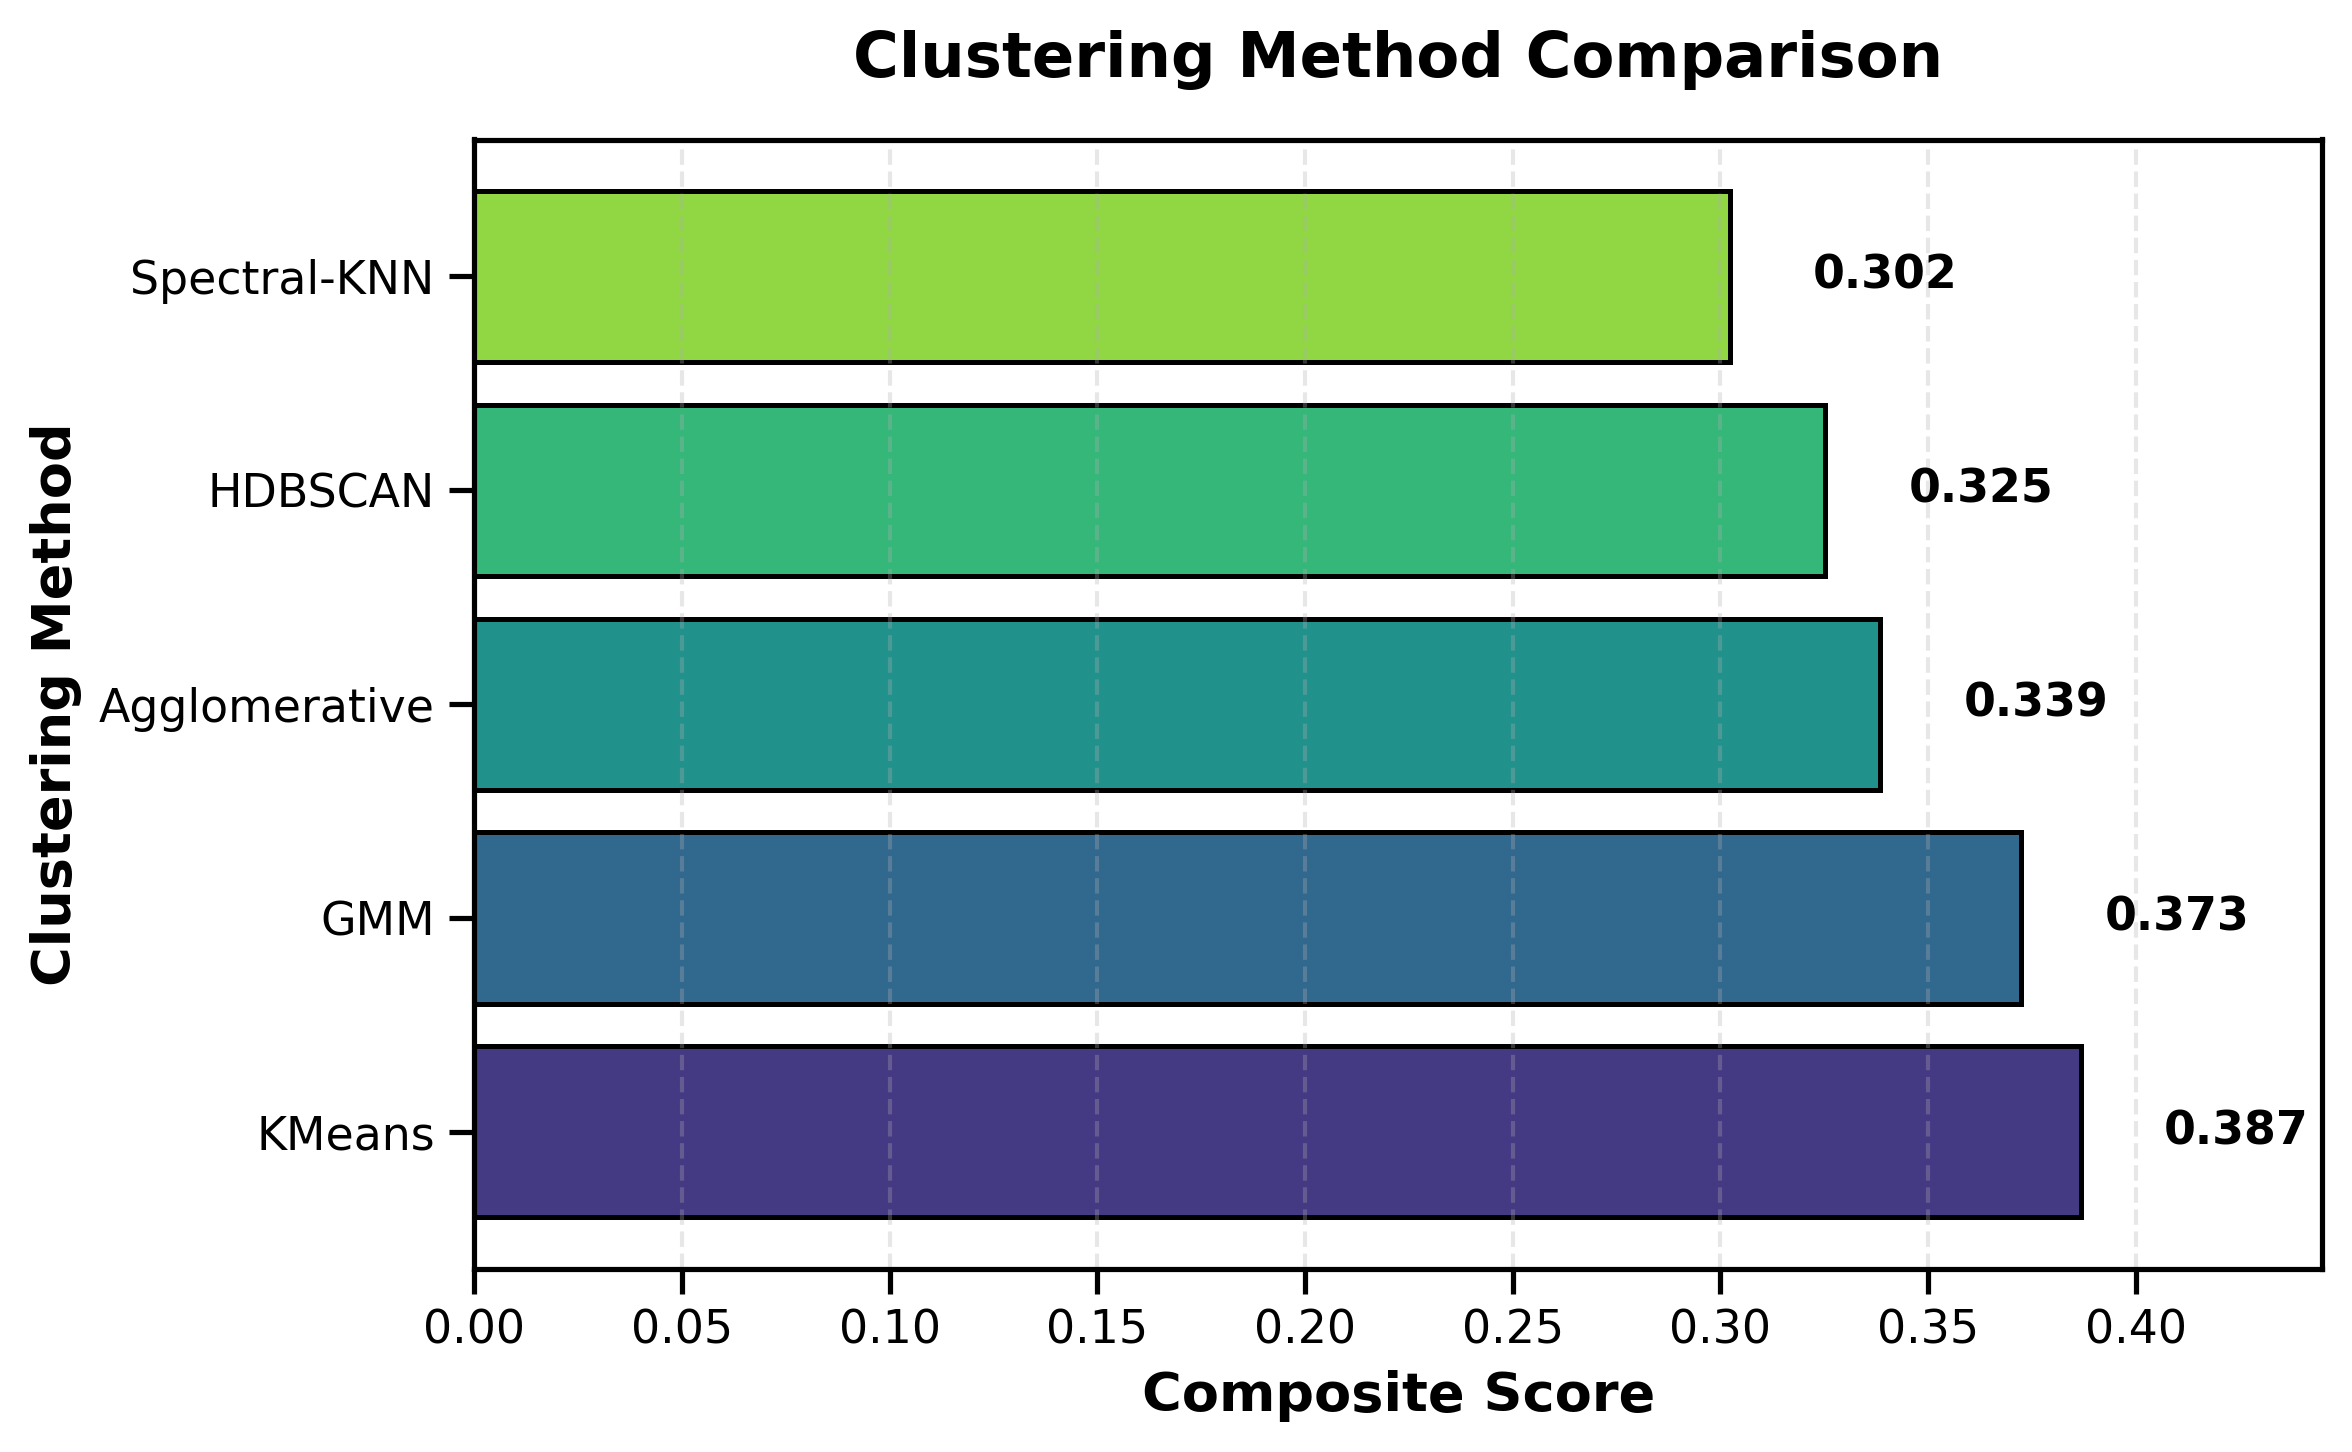

Saved bar chart to: /Users/yizj/Desktop/hbn_project/results/clustering_method_selection/composite_score_bar.png


In [50]:
# BAR CHART of Composite Scores

# --- Prepare data with method names ---
comp_plot = comp.copy()
comp_plot["name"] = list(labels_dict.keys())
comp_plot["name"] = comp_plot["name"].astype(str)

# Sort by composite score (best at top)
comp_plot = comp_plot.sort_values("composite_score", ascending=False)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

colors_palette = sns.color_palette("viridis", n_colors=len(comp_plot))
bars = ax.barh(
    y=comp_plot["name"], 
    width=comp_plot["composite_score"],
    color=colors_palette,
    edgecolor='black',
    linewidth=1.2
)

# Add value labels on bars
for bar, value in zip(bars, comp_plot["composite_score"]):
    width = bar.get_width()
    ax.text(
        width + 0.02,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.3f}',
        ha='left',
        va='center',
        fontsize=11,
        fontweight='bold'
    )

ax.set_xlabel('Composite Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Clustering Method', fontsize=13, fontweight='bold')
ax.set_title('Clustering Method Comparison', fontsize=15, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(0, comp_plot["composite_score"].max() * 1.15)
ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()

# Save
bar_path = RESULTS_DIR / "composite_score_bar.png"
plt.savefig(bar_path, bbox_inches="tight", dpi=300)
plt.show()
print(f"Saved bar chart to: {bar_path}")

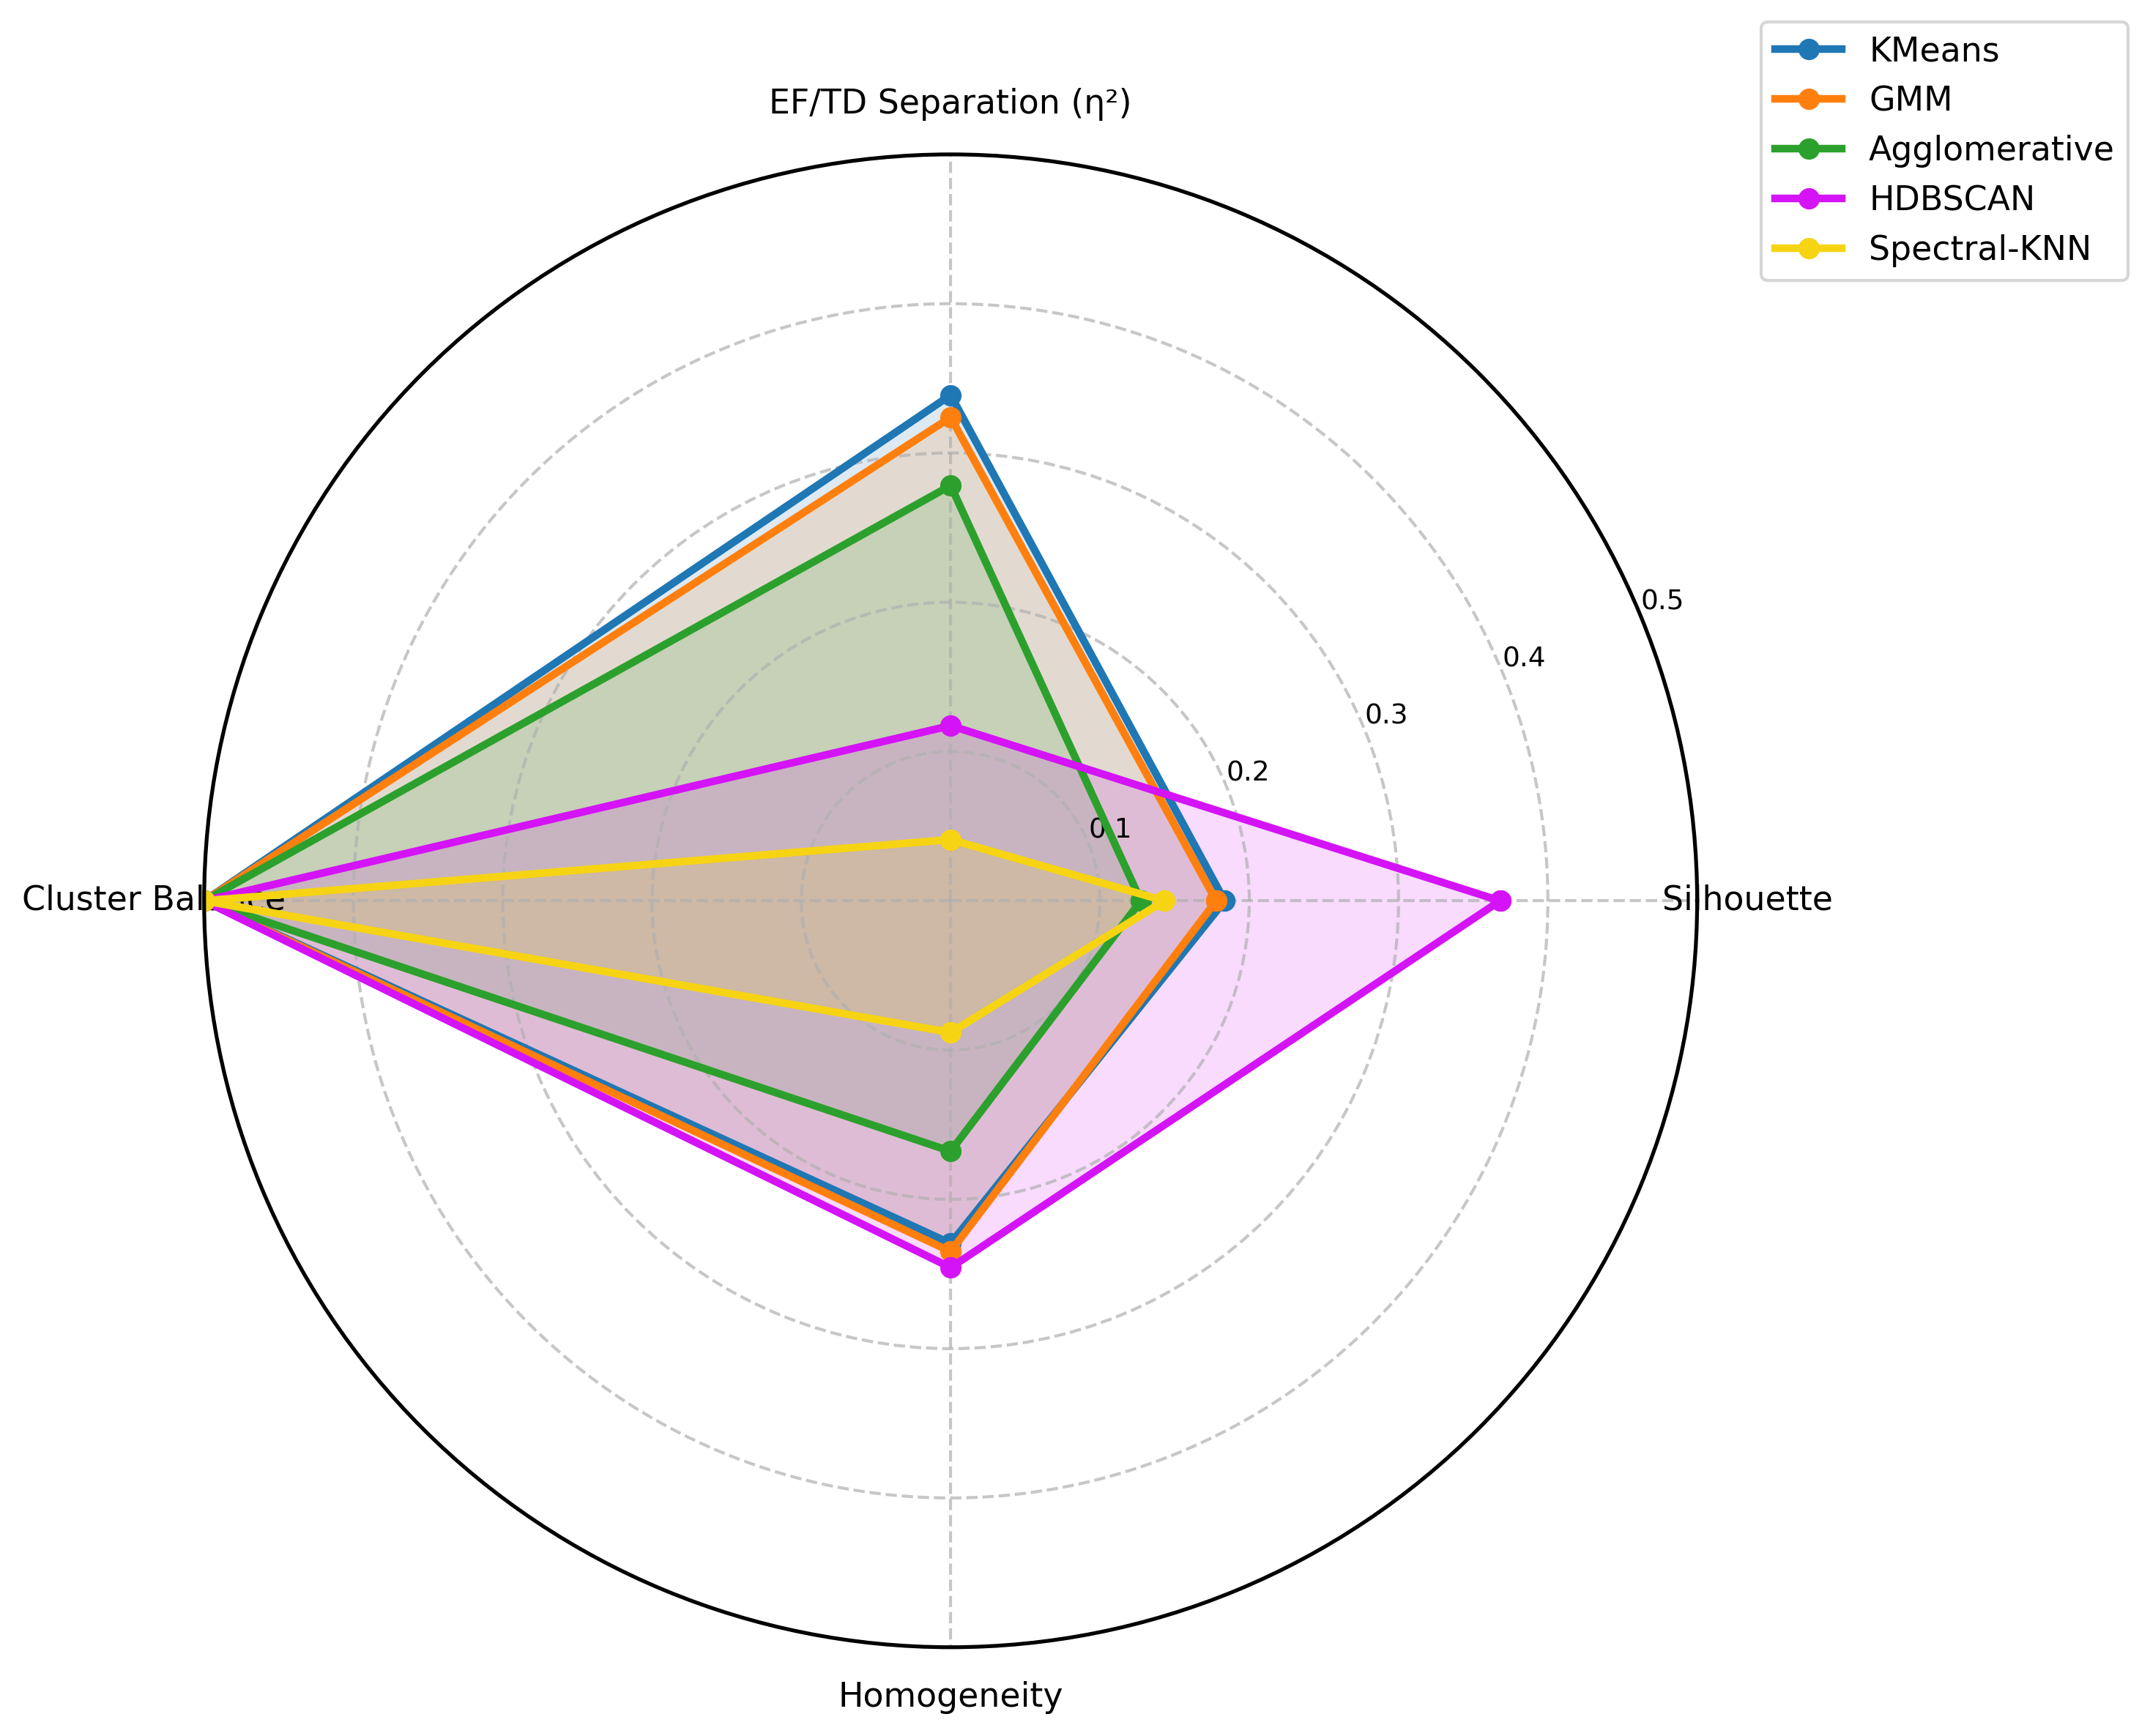

Saved radar chart to: /Users/yizj/Desktop/hbn_project/results/clustering_method_selection/method_comparison_radar.png


In [51]:

# -----------------------------------------------------------------------------
# RADAR/SPIDER CHART
# -----------------------------------------------------------------------------

# Take top 3 methods by composite score (comp_plot already sorted)
top_methods = comp_plot.head(5).copy()

metrics_radar = [
    "silhouette",
    "feature_separation_median_eta2",
    "cluster_balance",
    "cluster_homogeneity",
]

metric_labels = [
    "Silhouette",
    "EF/TD Separation (η²)",
    "Cluster Balance",
    "Homogeneity",
]

radar_data = top_methods[metrics_radar].astype(float)

num_vars = len(metrics_radar)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # close the loop

fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection='polar')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d413f6', '#f6d413']

for idx, (_, row) in enumerate(top_methods.iterrows()):
    values = radar_data.iloc[idx].values

    # Cap at 0.5 so the outer ring is 0.5
    values = np.minimum(values, 0.5)

    values = values.tolist()
    values += values[:1]

    ax.plot(
        angles, values, 'o-', linewidth=2.5,
        label=row["name"], color=colors[idx]
    )
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_labels, size=11)

ax.set_ylim(0, 0.5)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'], size=9)

ax.grid(True, linestyle='--', alpha=0.7)

#plt.title('Clustering Method Comparison (raw metrics, capped at 0.5)', size=15, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()

# Save
radar_path = RESULTS_DIR / "method_comparison_radar.png"
plt.savefig(radar_path, bbox_inches="tight", dpi=300)
plt.show()
print(f"Saved radar chart to: {radar_path}")

In [ ]:

# -----------------------------------------------------------------------------
# GROUPED BAR CHART
# -----------------------------------------------------------------------------

# Select key metrics to display
key_metrics = [
    "silhouette_x_coverage",
    "stability",
    "feature_separation_median_eta2",
    "composite_score"
]

metric_display = {
    "silhouette_x_coverage": "Sil × Cov",
    "stability": "Stability",
    "feature_separation_median_eta2": "EF/TD Sep",
    "composite_score": "Composite"
}

# Prepare data
bar_data = comp_plot[["name"] + key_metrics].set_index("name")
bar_data = bar_data.rename(columns=metric_display)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(11, 6), dpi=300)

x = np.arange(len(bar_data))
width = 0.2
multiplier = 0

colors_grouped = sns.color_palette("Set2", n_colors=len(bar_data.columns))

for i, (attribute, color) in enumerate(zip(bar_data.columns, colors_grouped)):
    offset = width * multiplier
    bars = ax.bar(x + offset, bar_data[attribute], width, 
                   label=attribute, color=color, edgecolor='black', linewidth=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)
    
    multiplier += 1

# Formatting
ax.set_xlabel('Clustering Method', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Clustering Method Performance Across Key Metrics', 
             fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x + width * (len(bar_data.columns) - 1) / 2)
ax.set_xticklabels(bar_data.index, fontsize=11)
ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save
#grouped_bar_path = RESULTS_DIR / "method_comparison_grouped_bars.png"
#plt.savefig(grouped_bar_path, bbox_inches="tight", dpi=300)
#plt.show()

#print(f"Saved grouped bar chart to: {grouped_bar_path}")

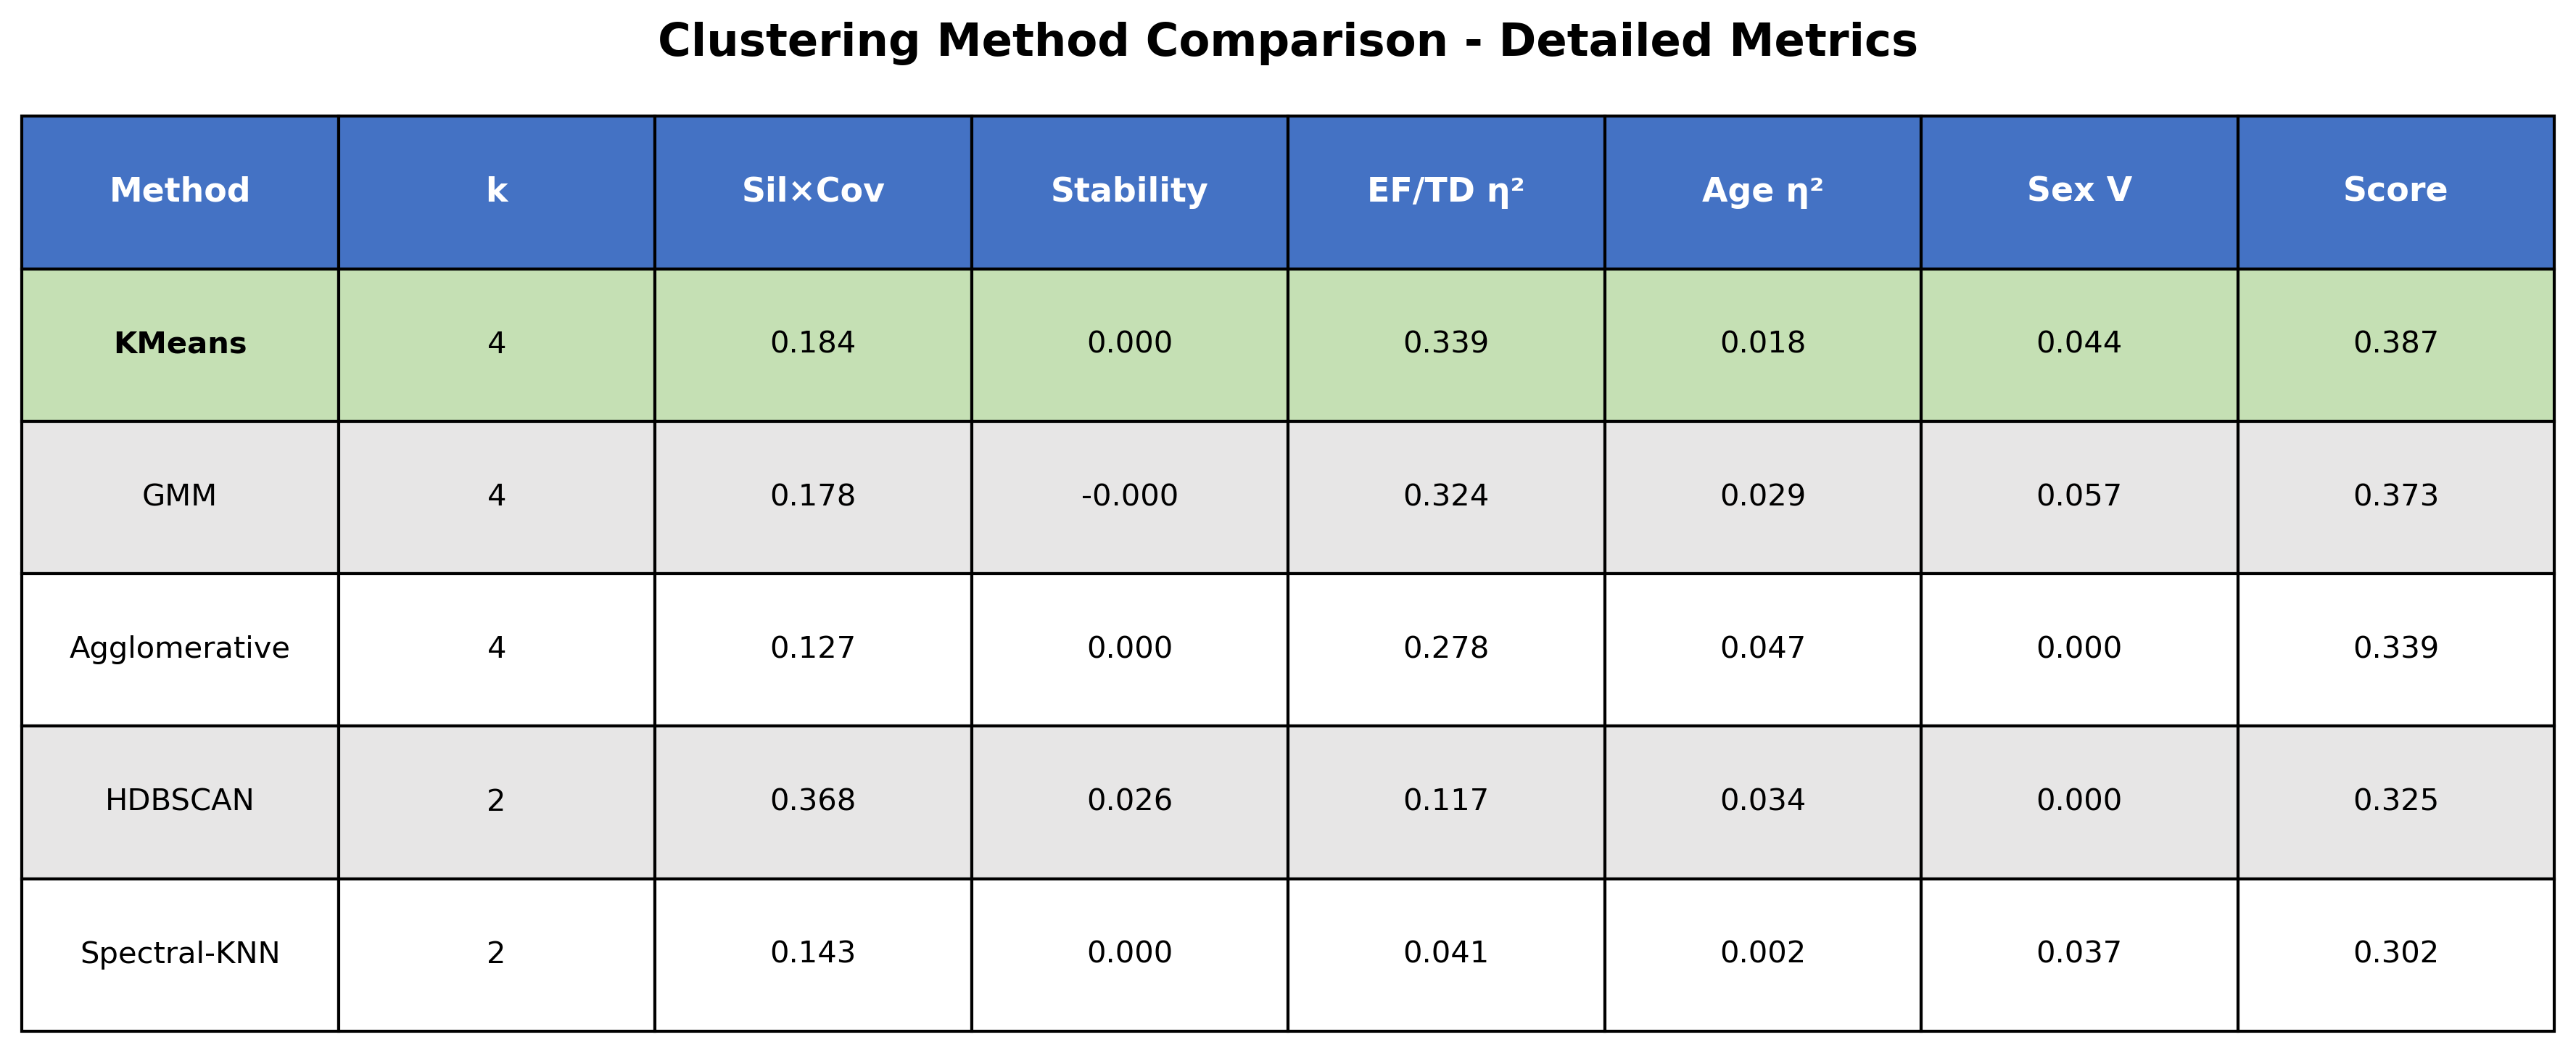

In [37]:

# -----------------------------------------------------------------------------
# TABLE
# -----------------------------------------------------------------------------

from matplotlib.patches import Rectangle

# Select metrics to display
table_metrics = [
    "n_clusters",
    "silhouette_x_coverage", 
    "stability",
    "feature_separation_median_eta2",
    "eta2_age",
    "cramersV_sex",
    "composite_score"
]

table_display = {
    "n_clusters": "k",
    "silhouette_x_coverage": "Sil×Cov",
    "stability": "Stability", 
    "feature_separation_median_eta2": "EF/TD η²",
    "eta2_age": "Age η²",
    "cramersV_sex": "Sex V",
    "composite_score": "Score"
}

# Prepare data
table_data = comp_plot[["name"] + table_metrics].copy()
table_data = table_data.rename(columns={"name": "Method", **table_display})

# Create figure
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Color header
for i in range(len(table_data.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Color rows alternately
for i in range(1, len(table_data) + 1):
    for j in range(len(table_data.columns)):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E7E6E6')
        else:
            cell.set_facecolor('white')
        
        # Highlight best method (row 1)
        if i == 1:
            cell.set_facecolor('#C5E0B4')
            if j == 0:  # Method name
                cell.set_text_props(weight='bold')

# Format numeric values
for i in range(1, len(table_data) + 1):
    for j in range(1, len(table_data.columns)):
        cell = table[(i, j)]
        try:
            val = float(cell.get_text().get_text())
            if j == 1:  # k (integer)
                cell.get_text().set_text(f'{int(val)}')
            else:
                cell.get_text().set_text(f'{val:.3f}')
        except:
            pass

plt.title('Clustering Method Comparison - Detailed Metrics', 
          fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()

# Save
#table_path = RESULTS_DIR / "method_comparison_table.png"
#plt.savefig(table_path, bbox_inches="tight", dpi=300)
#plt.show()

#print(f"Saved table to: {table_path}")

## Interpretation

| Column | What it measures | How it’s computed (short) | How to read it |
|---|---|---|---|
| **coverage** | % of rows that received a cluster label | `n_labeled / n_total`. Needed because some methods (e.g., HDBSCAN) mark “noise”. | Closer to **1.0** is better (more of your dataset is clustered). |
| **silhouette_x_coverage** | Compactness/separation of clusters **adjusted for coverage** | Silhouette score (∈[-1,1]) computed **only on labeled points** and then multiplied by `coverage` so a tiny, clean subset doesn’t look artificially great. | Larger is better. As rough guidance: ~0.00=weak, ~0.10–0.25=ok in messy human data, ≥0.30=good. |
| **stability** | How reproducible labels are under resampling | Bootstrap-based adjusted Rand index (ARI) on overlapping resamples (0–1). | Larger is better. ~0 means labels are unstable to small changes; ≥0.3 begins to look usable; ≥0.5 is solid. |
| **feature_separation_median_eta2** | Do clusters actually differ on the features you clustered on (EF/TD)? | For each EF/TD feature, η² from one-way ANOVA across clusters; then take the **median** across features (0–1). | Larger is better. Rule of thumb for η²: ~0.01=small, ~0.06=medium, ~0.14+=large. Median is robust to one odd feature dominating. |
| **eta2_age** | How much **Age** differences alone explain the clustering | η² for Age vs cluster labels (0–1). | **Lower** is better (you don’t want age to drive the solution). Values near 0.00–0.05 suggest age isn’t dominating. |
| **cramersV_sex** | Association between **Sex** and cluster labels | Bias-corrected Cramér’s V from the cluster×sex contingency table (0–1). | **Lower** is better. Heuristics: ~0.10=small, ~0.30=medium, ~0.50=large. |
| **cluster_balance** | Whether cluster sizes are balanced | Normalized entropy of cluster size proportions (0–1). | **Higher** is better; ~1 means sizes are even. Very low values mean a dominant cluster + tiny satellites. |
| **cluster_homogeneity** | Within-cluster tightness relative to overall spread | 1 − (mean within-cluster SD / overall SD), averaged across features (0–1). | **Higher** is better (tighter clusters). |
| **composite_score** | One number to compare methods | Weighted blend of the above (defaults: silhouette 0.20, stability 0.30, feature separation 0.30, **low** demographic confound 0.15, interpretability 0.05). | **Higher** is better. Use it to rank methods, then sanity-check profiles. |

---

## How to pick
1. **Scan `composite_score`**: take the top 1–2 candidates.
2. **Check the drivers**: you want **moderate+ `silhouette_x_coverage`** and **high `feature_separation_median_eta2`**.
3. **Guardrails**: ensure **`eta2_age` and `cramersV_sex` are small** (demographics not driving).
4. **Reliability**: prefer **higher `stability`** if two methods are close.
5. **Practicality**: avoid solutions with very poor **`cluster_balance`**.

---

- All rows show **coverage=1.00**, so every method labeled all rows (no noise left out).
- `silhouette_x_coverage` ranges ~0.14–0.37 → modest separation; the best row has the cleanest geometry.
- `feature_separation_median_eta2` spans ~0.041–0.339 → only the top one or two rows show **meaningful EF/TD separation**.
- `eta2_age` is ~0.002–0.047 and `cramersV_sex` ~0.000–0.057 → **demographics are not dominating** (good).
- `cluster_balance` is ≥0.60 (most ≈0.95+) → sizes are fairly even.
- The **row with the highest `composite_score`** is your current best overall trade-off; profile that one first and sanity-check the EF/TD heatmap.

Chosen method: KMeans


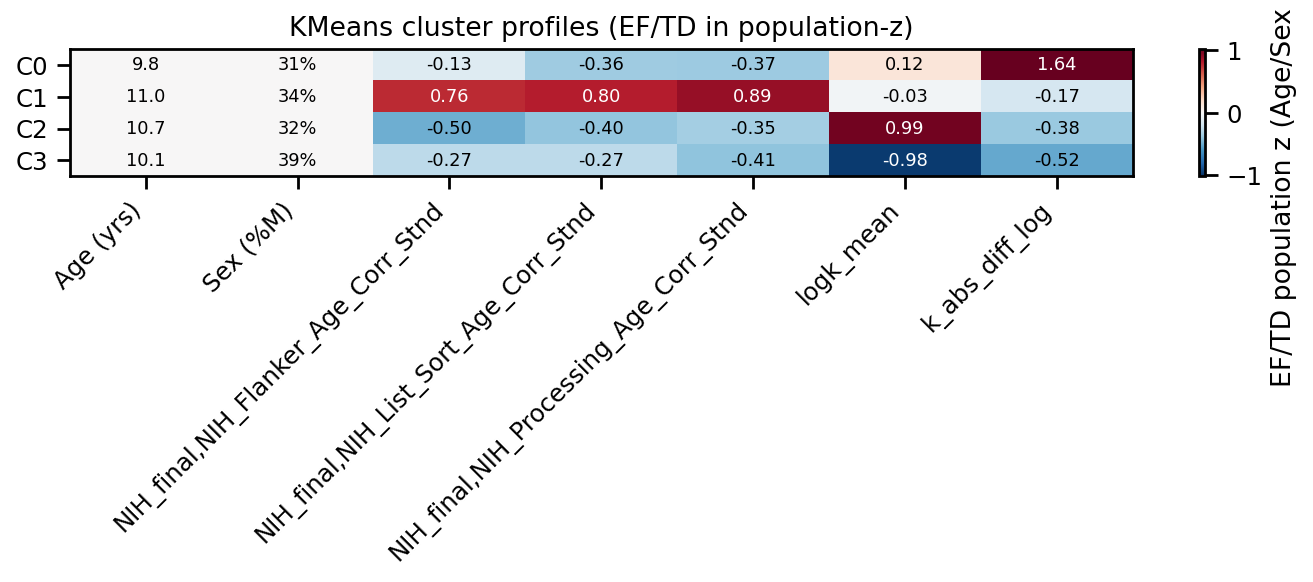

In [29]:
best_row = comp.iloc[0]
best_name = best_row["method"]
print("Chosen method:", best_name)

labs = labels_dict[best_name]["labels"]
valid = labels_dict[best_name]["valid"]

profile_table_and_heatmap_mixed(
    df_original=pd.concat([df[FEATURES], df[["Age","Sex"]]], axis=1),
    labels=labs,
    z_cols=FEATURES,  # EF/TD columns are z-colored; Age/Sex printed only
    title=f"{best_name} cluster profiles (EF/TD in population-z)"
)

# Explanation

I am comparing different clustering methods/parameter sets using **internal metrics** only (no diagnoses yet). The goal is:

> “Among all the candidate clusterings, which one gives me clusters that are (a) well separated in EF/TD space, (b) stable, and (c) interpretable, without just recapitulating age/sex?”

I summarize each clustering solution with the following metrics:

---

## 1. Silhouette (and silhouette × coverage)

**What I computed**

For each clustering solution, I used the **silhouette score**:

- For each child $i$:
  - $a(i)$: average distance to others in the **same** cluster  
  - $b(i)$: average distance to the **nearest other** cluster  
  - Silhouette:
  
    $$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

- Overall silhouette = mean of $s(i)$ across all children in the solution.

I also computed:

- **coverage** = proportion of the full sample assigned to non-noise clusters  
- **silhouette\_x\_coverage** = silhouette × coverage

**How to understand it**

- $s(i) \approx 1$: point is well placed (much closer to its own cluster than to others).  
- $s(i) \approx 0$: point is on the boundary between clusters.  
- $s(i) < 0$: point is probably misassigned.

For a full solution:

- Higher **silhouette** ⇒ clusters are more compact inside and more separated from each other.  
- Higher **coverage** ⇒ more of the sample is actually clustered (not excluded as noise).  
- Higher **silhouette\_x\_coverage** ⇒ **good separation over a large portion of the sample**.

In the composite score, I rescale silhouette\_x\_coverage to $[0,1]$ using  

$$
\frac{\text{silhouette\_x\_coverage} + 1}{2}
$$

and give it weight **0.20**.

---

## 2. EF/TD $\eta^2$ (`feature_separation_median_eta2`)

**What I computed**

For each EF/TD feature $y$ (e.g., Flanker, List Sort, processing speed, logk, inconsistency):

1. I treat cluster label as a group factor.  
2. I compute **$\eta^2$** from a one-way ANOVA:
   - $SS_{\text{total}}$: total variance in $y$  
   - $SS_{\text{between}}$: variance explained by differences between cluster means  
   - 
     $$
     \eta^2 = \frac{SS_{\text{between}}}{SS_{\text{total}}}
     $$

For each clustering solution:

- I compute $\eta^2$ for **each** EF/TD feature,  
- Drop NaNs,  
- Take the **median** across features → `feature_separation_median_eta2`.

**How to understand it**

- $\eta^2 \approx 0$: clusters do **not** explain much variance in that EF/TD feature.  
- Higher $\eta^2$: clusters explain a larger **proportion of variance** in that feature.

Taking the **median** across EF/TD features:

- High `feature_separation_median_eta2` ⇒ **on average**, EF/TD scores differ meaningfully across clusters.  
- This is a direct measure of “how strongly do these clusters carve up the EF/TD space?”

In the composite score, `feature_separation_median_eta2` enters **directly** (0–1) and gets a **0.30** weight.

---

## 3. Cluster balance

**What I computed**

For each solution, I look at how many children are in each cluster:

- Let $p_k$ be the proportion in cluster $k$.  
- Compute the **entropy**:

  $$
  H = -\sum_k p_k \log_2(p_k)
  $$

- Maximum entropy is $\log_2(K)$ when all clusters are perfectly equal.  
- I normalize:

  $$
  \text{cluster\_balance} = \frac{H}{\log_2(K)}
  $$

**How to understand it**

- Values range from 0 to 1.  
  - $\approx 1$ ⇒ clusters are **balanced** (similar sizes).  
  - $\approx 0$ ⇒ one cluster dominates and others are tiny (or virtually empty).

Balanced clusters are more interpretable and more likely to be stable, because they are not just a big blob plus tiny “dust” clusters.

`cluster_balance` itself is not in the main part of the composite, but it contributes (together with homogeneity) to a small **interpretability** term.

---

## 4. Cluster homogeneity

**What I computed**

For each EF/TD feature $c$:

1. Compute the **overall** standard deviation, $\text{sd\_all}(c)$.  
2. For each cluster, compute the **within-cluster** SD of $c$, then take the **mean** across clusters:
   
   $$
   \text{mean\_within\_sd}(c) = \text{average}\big(\text{sd of } c \text{ within each cluster}\big)
   $$
3. Compute the ratio:
   
   $$
   \text{ratio}(c) = \frac{\text{mean\_within\_sd}(c)}{\text{sd\_all}(c)}
   $$
4. Average these ratios across all EF/TD features, then define:
   
   $$
   \text{cluster\_homogeneity} = 1 - \text{average\_ratio}
   $$

**How to understand it**

- If clusters are **very tight** relative to the overall spread:  
  - within-cluster SDs are small → ratios are small → homogeneity close to 1.  
- If clusters are not much tighter than the overall sample:  
  - ratios are near 1 → homogeneity near 0.

So higher **cluster\_homogeneity** means:

> “On average, scores inside each cluster vary less than scores in the full sample.”  

This is another measure of how “coherent” each cluster is in EF/TD space.

Again, `cluster_homogeneity` enters the composite as part of a small **interpretability** term.

---

## Composite score

For each clustering method, I combine several metrics into a **single composite score** to rank methods:

1. **Silhouette × coverage** (separation + how many points are clustered)  
   - Rescaled to $[0,1]$ using $(s+1)/2$  
   - Weight: **0.20**

2. **Stability** (bootstrap ARI; from another part of the evaluator)  
   - Measures how reproducible the solution is across resampled data  
   - Raw value in $[0,1]$  
   - Weight: **0.30**

3. **Feature separation (median EF/TD $\eta^2$)**  
   - Higher ⇒ clusters explain more EF/TD variance  
   - Raw value in $[0,1]$  
   - Weight: **0.30**

4. **Low demographic confounding (age/sex)**  
   - I compute a “demo” strength:
     
     $$
     \text{demo} = \max\big(\eta^2_{\text{age}}, (\text{Cramér's V}_{\text{sex}})^2\big)
     $$
   - Then encourage *smaller* demo:
     
     $$
     \text{low\_demo} = \max\big(0,\ 1 - \text{demo}/0.20\big)
     $$
   - If age/sex explain a lot of cluster variation ($\text{demo} \ge 0.20$), this term goes toward 0.  
   - Weight: **0.15**

5. **Interpretability (balance + homogeneity)**  
   - Simple mean:
     
     $$
     \text{interpret} = \text{mean}(\text{cluster\_balance}, \text{cluster\_homogeneity})
     $$
   - Encourages solutions that have **reasonably even cluster sizes** and **tight clusters**.  
   - Weight: **0.05**

The composite score is then:

$$
\text{composite} =
0.20 \cdot \widetilde{\text{silhouette\_x\_coverage}} +
0.30 \cdot \text{stability} +
0.30 \cdot \text{feature\_separation\_median\_eta2} +
0.15 \cdot \text{low\_demo} +
0.05 \cdot \text{interpret}
$$

(where $\widetilde{\;\cdot\;}$ denotes the rescaled `silhouette_x_coverage`).

---

Overall, the weighting scheme encodes the following priorities:

1. **First, do no harm to validity**:  
   - Prefer solutions that are **reproducible** (stability) and genuinely
     **carve up EF/TD space** (feature separation).

2. **Second, ensure reasonable geometric quality**:  
   - Clusters should be **coherent and separated** for a large portion of the
     sample (silhouette × coverage).

3. **Third, avoid trivial demographic partitions**:  
   - Age/sex should not be the dominant explanation for the clusters (low_demo).

4. **Fourth, reward extra interpretability**:  
   - Balanced, homogeneous clusters are easier to describe and use, but only
     after validity and EF/TD relevance are satisfied (interpret term).

The exact numeric weights (0.30, 0.30, 0.20, 0.15, 0.05) are therefore
**explicitly heuristic** and reflect these priorities. I also verified that the
relative ranking of candidate solutions is qualitatively robust to moderate
changes in weights, which supports the use of this composite score as a
transparent and pragmatic selection tool, rather than a fragile or arbitrary
choice.

## How to interpret my specific results

- The **chosen method** (highest composite score) is the one that:
  - Achieved **good silhouette\_x\_coverage**: reasonably separated clusters covering a large portion of the sample,
  - Showed **strong EF/TD separation** (higher median $\eta^2$ than competing methods),
  - Had **decent stability** across bootstrap resamples,
  - Was **not primarily driven by age/sex** (demo term not too large),
  - Had **usable cluster sizes** and **reasonably homogeneous clusters** (balance + homogeneity).

In other words, the selected clustering is not just the one with the highest silhouette alone, or the most balanced sizes alone, but the one that **best trades off**:

- Separation in EF/TD space,  
- Stability,  
- Limited demographic confounding, and  
- Interpretability (balanced, coherent clusters).

This is the solution I carry forward to profile in terms of EF/TD, diagnoses, and (later) dimensional symptom/impairment measures.